# BLE Proximity Experiment - KNN Classifier
## Experiment based on the measurements of the BLE RSSI values according to the distance to the BLE Estimote beacon

### Imports
Imports of required libraries

In [1]:
#CSV Related
import pandas as pd
import csv

# Machine Learning
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder,LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split,KFold,StratifiedKFold
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.preprocessing import StandardScaler, MinMaxScaler, MaxAbsScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.pipeline import make_pipeline
import sklearn
import scipy

#Graphical Display
%matplotlib inline
from IPython.display import display, HTML
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns
sns.set_style("whitegrid")
sns.despine()
from pandas.plotting import scatter_matrix

# Create color maps
cmap_light = ListedColormap(['orange', 'cyan', 'cornflowerblue'])
cmap_bold = ListedColormap(['darkorange', 'c', 'darkblue'])

plt.style.use('seaborn-whitegrid')

#Additional Helper Libraries
from operator import itemgetter
import re

<Figure size 432x288 with 0 Axes>

### Load File
Function that allows to load a file from disk

In [2]:
#Function that reads a csv file and structures the data accordingly
def load_file(filename):
    dataset = pd.read_csv(filename)
    return dataset

### Replace 0 with Nan RSSI Values

In [3]:
def replace_features_nan(dataset):
    dataset['rssi_Value'] = dataset['rssi_Value'].replace(0,np.nan)
    dataset['rolling_mean_rssi'] = dataset['rolling_mean_rssi'].replace(0,np.nan)

### Initialize Dataset
Initialization of the data from the file

In [4]:
dataset = load_file('../../dataset_train_university.csv')
positions = dataset['coordinate_Y']
dataset['distance'] = positions
replace_features_nan(dataset)
display(dataset)
display(dataset.shape)

,coordinate_X,coordinate_Y,rssi_Value,rolling_mean_rssi,zone,distance
0,0.0,0.0,-48,-48.000000,Personal,0.0
1,0.0,0.0,-48,-48.000000,Personal,0.0
2,0.0,0.0,-48,-48.000000,Personal,0.0
3,0.0,0.0,-48,-48.000000,Personal,0.0
4,0.0,0.0,-46,-47.600000,Personal,0.0
...,...,...,...,...,...,...
24829,0.0,4.5,-92,-90.480000,Public,4.5
24830,0.0,4.5,-93,-90.576923,Public,4.5
24831,0.0,4.5,-90,-90.555556,Public,4.5
24832,0.0,4.5,-90,-90.535714,Public,4.5


(24834, 6)

### Initialize Test Set

,coordinate_X,coordinate_Y,rssi_Value,rolling_mean_rssi,zone,distance
0,0.0,4.5,-86,-86.000000,Public,4.5
1,0.0,4.5,-84,-85.000000,Public,4.5
2,0.0,4.5,-83,-84.333333,Public,4.5
3,0.0,4.5,-84,-84.250000,Public,4.5
4,0.0,4.5,-92,-85.800000,Public,4.5
...,...,...,...,...,...,...
3672,0.0,0.0,-57,-56.814815,Personal,0.0
3673,0.0,0.0,-56,-56.785714,Personal,0.0
3674,0.0,0.0,-56,-56.758621,Personal,0.0
3675,0.0,0.0,-56,-56.733333,Personal,0.0


(3677, 6)

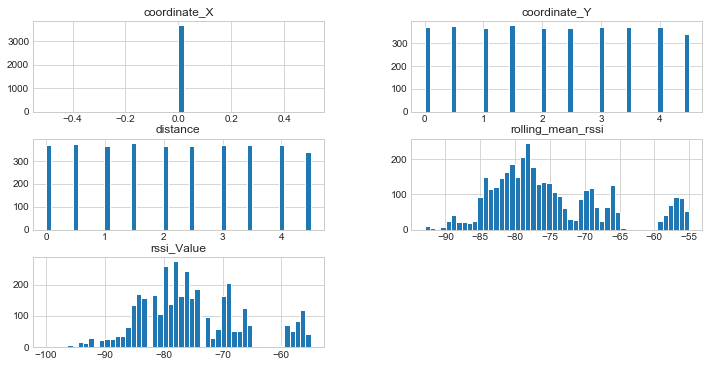

In [5]:
test_dataset = load_file('../../dataset_test_university.csv')
positions = test_dataset['coordinate_Y']
test_dataset['distance'] = positions
replace_features_nan(test_dataset)
display(test_dataset)
display(test_dataset.shape)
test_dataset.hist(bins=50,figsize=(12,6))
plt.show()

### Initialize Test Set (HOME | BIG DATASET SAMSUNG)

,coordinate_X,coordinate_Y,rssi_Value,rolling_mean_rssi,zone,distance
0,0.0,0.0,-47,-47.000000,Personal,0.0
1,0.0,0.0,-46,-46.500000,Personal,0.0
2,0.0,0.0,-46,-46.333333,Personal,0.0
3,0.0,0.0,-47,-46.500000,Personal,0.0
4,0.0,0.0,-47,-46.600000,Personal,0.0
...,...,...,...,...,...,...
12470,0.0,3.5,-87,-84.555556,Social,3.5
12471,0.0,3.5,-87,-84.684211,Social,3.5
12472,0.0,3.5,-87,-84.800000,Social,3.5
12473,0.0,3.5,-87,-84.904762,Social,3.5


(12475, 6)

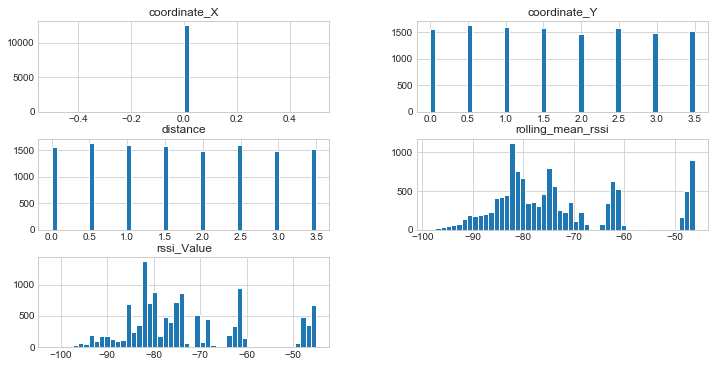

In [6]:
test_dataset_home_big = load_file('../../dataset_test_home_big.csv')
positions = test_dataset_home_big['coordinate_Y']
test_dataset_home_big['distance'] = positions
replace_features_nan(test_dataset_home_big)
display(test_dataset_home_big)
display(test_dataset_home_big.shape)
test_dataset_home_big.hist(bins=50,figsize=(12,6))
plt.show()

### Initialize Test Set (HOME | SMALL DATASET SAMSUNG)

,coordinate_X,coordinate_Y,rssi_Value,rolling_mean_rssi,zone,distance
0,0.0,0.0,-44,-44.000000,Personal,0.0
1,0.0,0.0,-44,-44.000000,Personal,0.0
2,0.0,0.0,-44,-44.000000,Personal,0.0
3,0.0,0.0,-44,-44.000000,Personal,0.0
4,0.0,0.0,-45,-44.200000,Personal,0.0
...,...,...,...,...,...,...
2279,0.0,3.5,-84,-83.944444,Social,3.5
2280,0.0,3.5,-85,-84.000000,Social,3.5
2281,0.0,3.5,-85,-84.050000,Social,3.5
2282,0.0,3.5,-92,-84.428571,Social,3.5


(2284, 6)

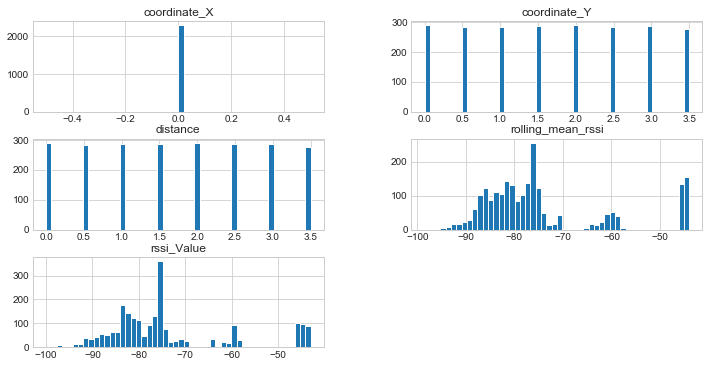

In [7]:
test_dataset_home_small = load_file('../../dataset_test_home.csv')
positions = test_dataset_home_small['coordinate_Y']
test_dataset_home_small['distance'] = positions
replace_features_nan(test_dataset_home_small)
display(test_dataset_home_small)
display(test_dataset_home_small.shape)
test_dataset_home_small.hist(bins=50,figsize=(12,6))
plt.show()

### Initialize Test Set (HOME | SMALL DATASET ASUS)

,coordinate_X,coordinate_Y,rssi_Value,rolling_mean_rssi,zone,distance
0,0.0,0.0,-50,-50.000000,Personal,0.0
1,0.0,0.0,-50,-50.000000,Personal,0.0
2,0.0,0.0,-53,-51.000000,Personal,0.0
3,0.0,0.0,-51,-51.000000,Personal,0.0
4,0.0,0.0,-53,-53.000000,Personal,0.0
...,...,...,...,...,...,...
410,0.0,3.5,-86,-83.800000,Social,3.5
411,0.0,3.5,-88,-84.500000,Social,3.5
412,0.0,3.5,-84,-84.428571,Social,3.5
413,0.0,3.5,-83,-84.250000,Social,3.5


(415, 6)

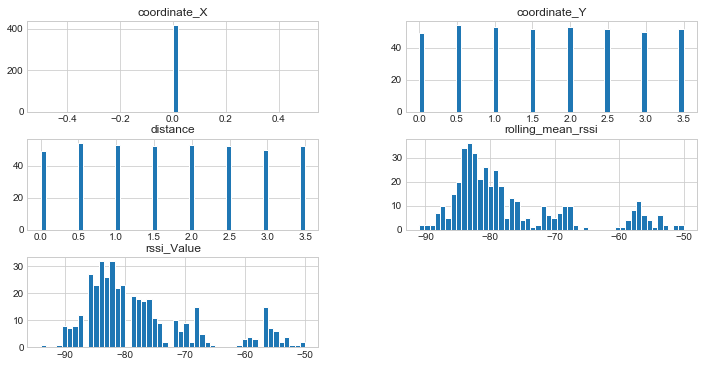

In [8]:
test_dataset_home_asus = load_file('../../dataset_test_home_asus.csv')
positions = test_dataset_home_asus['coordinate_Y']
test_dataset_home_asus['distance'] = positions
replace_features_nan(test_dataset_home_asus)
display(test_dataset_home_asus)
display(test_dataset_home_asus.shape)
test_dataset_home_asus.hist(bins=50,figsize=(12,6))
plt.show()

### Dataset Overall Info

In [9]:
display(dataset.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24834 entries, 0 to 24833
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   coordinate_X       24834 non-null  float64
 1   coordinate_Y       24834 non-null  float64
 2   rssi_Value         24834 non-null  int64  
 3   rolling_mean_rssi  24834 non-null  float64
 4   zone               24834 non-null  object 
 5   distance           24834 non-null  float64
dtypes: float64(4), int64(1), object(1)
memory usage: 1.1+ MB


None

### File Overall Description
Usage of describe pandas function on the dataset

In [10]:
display(dataset.describe().transpose())

,count,mean,std,min,25%,50%,75%,max
coordinate_X,24834.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0
coordinate_Y,24834.0,2.210196,1.436557,0.0,1.000000,2.0,3.500000,4.5
rssi_Value,24834.0,-76.687243,11.255077,-102.0,-84.000000,-78.0,-73.000000,-46.0
rolling_mean_rssi,24834.0,-76.677952,10.969519,-99.0,-83.666667,-78.5,-73.767308,-46.0
distance,24834.0,2.210196,1.436557,0.0,1.000000,2.0,3.500000,4.5


### % of Missing Values

In [11]:
def compute_missing_values(dataset): 
    missing_values = dataset.isnull().sum()
    missing_values_dataset = pd.DataFrame(missing_values,columns=['Missing Values'])
    missing_percentage = (dataset.isnull().sum() / dataset.count())
    missing_percentage_dataset = pd.DataFrame(missing_percentage,columns=['% of Missing Values'])
    missing_dataset = missing_values_dataset.join(missing_percentage_dataset)
    display(missing_dataset)

In [12]:
compute_missing_values(dataset)

,Missing Values,% of Missing Values
coordinate_X,0,0.0
coordinate_Y,0,0.0
rssi_Value,0,0.0
rolling_mean_rssi,0,0.0
zone,0,0.0
distance,0,0.0


### Overall Histogram of dataset atributes

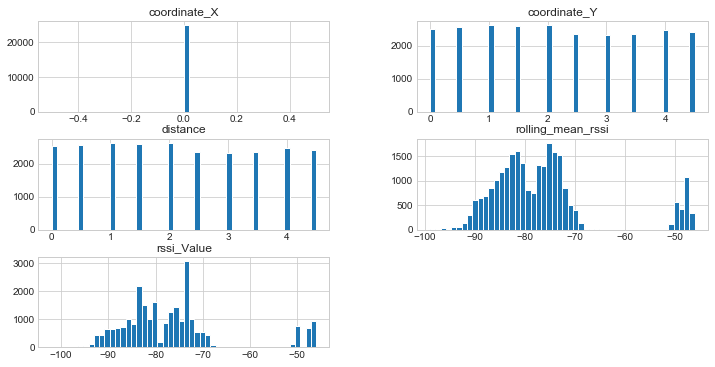

In [13]:
dataset.hist(bins=50,figsize=(12,6))
plt.show()

### Target Attribute - Zone
Graphical display of the zones scanned in the experiment

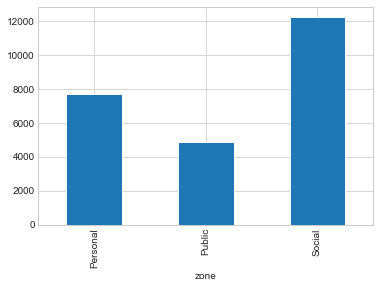

In [14]:
reference_points = dataset.groupby(['zone'])
reference_points.size().plot(kind="bar")

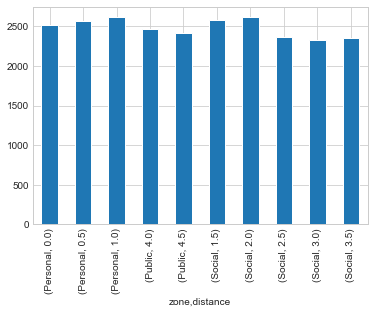

In [15]:
reference_points = dataset.groupby(['zone','distance'])
reference_points.size().plot(kind="bar")

### Beacon RSSI Display
Graphical display of the rssi values recorded at each position

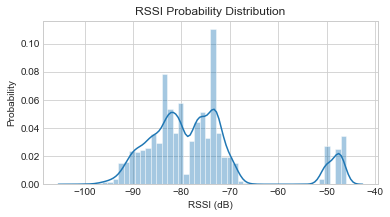

In [16]:
plt.figure(figsize=(6,3))
# Title
plt.title('RSSI Probability Distribution')

sns.distplot(dataset['rssi_Value'])
# The X Label
plt.xlabel('RSSI (dB)')
# The Y Label
plt.ylabel('Probability')
# Show the plot
plt.show()

### Beacon Rolling Mean RSSI Display
Graphical adisplay of the rolling mean value recorded at each position

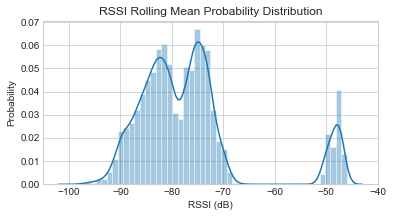

In [17]:
plt.figure(figsize=(6,3))
# Title
plt.title('RSSI Rolling Mean Probability Distribution')
# The KDE plot for the Rolling Mean column
sns.distplot(dataset['rolling_mean_rssi'])
# The X Label
plt.xlabel('RSSI (dB)')
# The Y Label
plt.ylabel('Probability')
# Show the plot
plt.show()

### Graphical Display of RSSI/Rolling Mean Distribution
Graphical display of the previous measures - rssi and rolling mean

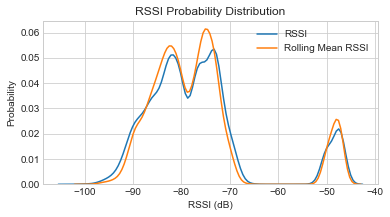

In [18]:
plt.figure(figsize=(6,3))
# Title
plt.title('RSSI Probability Distribution')
# The KDE plot for the RSSI column
sns.kdeplot(dataset['rssi_Value'], label='RSSI')
# The KDE plot for the Rolling Mean column
sns.kdeplot(dataset['rolling_mean_rssi'], label='Rolling Mean RSSI')
# The X Label
plt.xlabel('RSSI (dB)')
# The Y Label
plt.ylabel('Probability')
# Show the plot
plt.show()

### Correlations
Check how much each attribute collerates with each other. Valures frange from -1 to 1. Close to 1 means a strong positive correlation.

In [19]:
def compute_correlations(dataset):
    corr_matrix = dataset.corr()
    display(corr_matrix)
    display(corr_matrix['distance'].sort_values(ascending=False))
    attributes = ["distance","rssi_Value", "rolling_mean_rssi"]
    scatter_matrix(dataset[attributes], figsize=(12, 8))

,coordinate_X,coordinate_Y,rssi_Value,rolling_mean_rssi,distance
coordinate_X,NaN,NaN,NaN,NaN,NaN
coordinate_Y,NaN,1.000000,-0.723705,-0.741381,1.000000
rssi_Value,NaN,-0.723705,1.000000,0.958999,-0.723705
rolling_mean_rssi,NaN,-0.741381,0.958999,1.000000,-0.741381
distance,NaN,1.000000,-0.723705,-0.741381,1.000000


distance             1.000000
coordinate_Y         1.000000
rssi_Value          -0.723705
rolling_mean_rssi   -0.741381
coordinate_X              NaN
Name: distance, dtype: float64

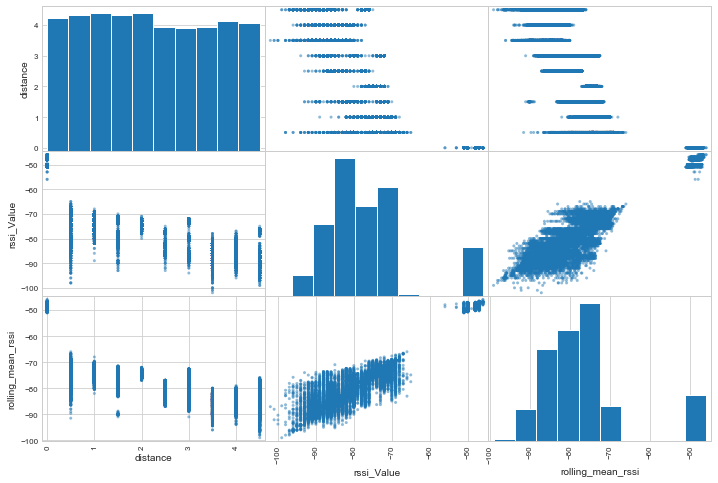

In [20]:
compute_correlations(dataset)

### Data Cleaning
Fill in missing values and fix/remove outliers

In [21]:
def compute_data_cleaning(dataset,feature):
    nan_filler = dataset[feature].min()*1.010
    dataset[feature] = dataset[feature].fillna(nan_filler) # Fill missing values

In [22]:
compute_data_cleaning(dataset,'rssi_Value')
compute_data_cleaning(dataset,'rolling_mean_rssi')
compute_data_cleaning(test_dataset,'rssi_Value')
compute_data_cleaning(test_dataset,'rolling_mean_rssi')
compute_data_cleaning(test_dataset_home_big,'rssi_Value')
compute_data_cleaning(test_dataset_home_big,'rolling_mean_rssi')
compute_data_cleaning(test_dataset_home_small,'rssi_Value')
compute_data_cleaning(test_dataset_home_small,'rolling_mean_rssi')
compute_data_cleaning(test_dataset_home_asus,'rssi_Value')
compute_data_cleaning(test_dataset_home_asus,'rolling_mean_rssi')

### Dealing with Categorical Data
Using Hot-Encoder or Label Encoder to convert text/categorical data into numerical data. ML algorithms prefer it

In [23]:
label_encoder = LabelEncoder()
def compute_encoder(categorical_data,flag):
    if flag == 0:
        labels = label_encoder.fit_transform(categorical_data)
    else:
        labels = label_encoder.transform(categorical_data)
    return labels

In [24]:
categorical_zone = dataset[['zone']]
print("Previous Categorical Data")
display(categorical_zone)
zone_changed = compute_encoder(categorical_zone,0)
print("After One Hot Encoder")
dataset['labels'] = zone_changed
train_Y = dataset['labels'].values.reshape(-1,1)
display(train_Y)

Previous Categorical Data


,zone
0,Personal
1,Personal
2,Personal
3,Personal
4,Personal
...,...
24829,Public
24830,Public
24831,Public
24832,Public


After One Hot Encoder


D:\Programs\Anaconda\lib\site-packages\sklearn\preprocessing\_label.py:251: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


array([[0],
       [0],
       [0],
       ...,
       [1],
       [1],
       [1]])

In [25]:
categorical_zone = test_dataset[['zone']]
print("Previous Categorical Data")
display(categorical_zone)
test_changed = compute_encoder(categorical_zone,1)
print("After One Hot Encoder")
test_dataset['labels'] = test_changed
test_Y = test_dataset['labels'].values.reshape(-1,1)
display(test_Y.shape)

Previous Categorical Data


,zone
0,Public
1,Public
2,Public
3,Public
4,Public
...,...
3672,Personal
3673,Personal
3674,Personal
3675,Personal


After One Hot Encoder


D:\Programs\Anaconda\lib\site-packages\sklearn\preprocessing\_label.py:268: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


(3677, 1)

In [26]:
categorical_zone = test_dataset_home_big[['zone']]
print("Previous Categorical Data")
display(categorical_zone)
test_changed = compute_encoder(categorical_zone,1)
print("After One Hot Encoder")
test_dataset_home_big['labels'] = test_changed
test_Y_home_big = test_dataset_home_big['labels'].values.reshape(-1,1)
display(test_Y_home_big.shape)

Previous Categorical Data


,zone
0,Personal
1,Personal
2,Personal
3,Personal
4,Personal
...,...
12470,Social
12471,Social
12472,Social
12473,Social


After One Hot Encoder


D:\Programs\Anaconda\lib\site-packages\sklearn\preprocessing\_label.py:268: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


(12475, 1)

In [27]:
categorical_zone = test_dataset_home_small[['zone']]
print("Previous Categorical Data")
display(categorical_zone)
test_changed = compute_encoder(categorical_zone,1)
print("After One Hot Encoder")
test_dataset_home_small['labels'] = test_changed
test_Y_home_small = test_dataset_home_small['labels'].values.reshape(-1,1)
display(test_Y_home_small.shape)

Previous Categorical Data


,zone
0,Personal
1,Personal
2,Personal
3,Personal
4,Personal
...,...
2279,Social
2280,Social
2281,Social
2282,Social


After One Hot Encoder


D:\Programs\Anaconda\lib\site-packages\sklearn\preprocessing\_label.py:268: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


(2284, 1)

In [28]:
categorical_zone = test_dataset_home_asus[['zone']]
print("Previous Categorical Data")
display(categorical_zone)
test_changed = compute_encoder(categorical_zone,1)
print("After One Hot Encoder")
test_dataset_home_asus['labels'] = test_changed
test_Y_home_asus = test_dataset_home_asus['labels'].values.reshape(-1,1)
display(test_Y_home_asus.shape)

Previous Categorical Data


,zone
0,Personal
1,Personal
2,Personal
3,Personal
4,Personal
...,...
410,Social
411,Social
412,Social
413,Social


After One Hot Encoder


D:\Programs\Anaconda\lib\site-packages\sklearn\preprocessing\_label.py:268: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


(415, 1)

### Initialize Training Data
Training Data intialization for predictions purposes

In [29]:
train_X_rssi = pd.DataFrame(dataset['rssi_Value']).values.reshape(-1,1)
display(train_X_rssi.shape)
train_X_rolling_mean = pd.DataFrame(dataset['rolling_mean_rssi']).values.reshape(-1,1)
display(train_X_rolling_mean.shape)
combination_features_X = dataset[['rssi_Value','rolling_mean_rssi']]
display(combination_features_X.shape)

(24834, 1)

(24834, 1)

(24834, 2)

In [30]:
data_plot_means = dataset.groupby(['zone'])[['rssi_Value','rolling_mean_rssi']].mean()
display(data_plot_means)

,rssi_Value,rolling_mean_rssi
zone,,
Personal,-66.101350,-66.075278
Public,-84.953374,-84.856790
Social,-80.050008,-80.086162


### Plot Training Data
Graphical Display of the observations in the dataset

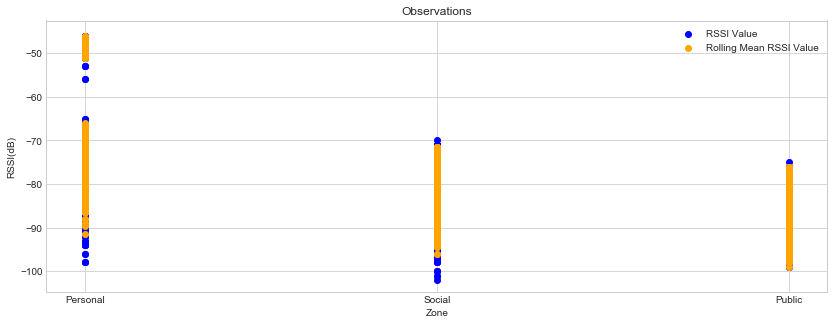

In [31]:
plt.figure(figsize=(14,5))
plt.scatter(dataset['zone'],dataset['rssi_Value'],label='RSSI Value',color='blue')
plt.scatter(dataset['zone'],dataset['rolling_mean_rssi'],label='Rolling Mean RSSI Value',color='orange')
plt.title('Observations')  
plt.xlabel('Zone')  
plt.ylabel('RSSI(dB)')  
plt.legend(loc='upper right');
plt.show()

### Initialize Test Data

In [32]:
test_X_rssi = pd.DataFrame(test_dataset['rssi_Value']).values.reshape(-1,1)
display(test_X_rssi.shape)
test_X_rolling_mean = pd.DataFrame(test_dataset['rolling_mean_rssi']).values.reshape(-1,1)
display(test_X_rolling_mean.shape)
test_combination_features_X = test_dataset[['rssi_Value','rolling_mean_rssi']]
display(test_combination_features_X.shape)

(3677, 1)

(3677, 1)

(3677, 2)

In [33]:
data_plot_means = test_dataset.groupby(['zone'])[['rssi_Value','rolling_mean_rssi']].mean()
display(data_plot_means)

,rssi_Value,rolling_mean_rssi
zone,,
Personal,-66.634563,-66.593533
Public,-81.438819,-81.521907
Social,-78.235580,-78.069045


In [34]:
test_X_rssi_home_big = pd.DataFrame(test_dataset_home_big['rssi_Value']).values.reshape(-1,1)
display(test_X_rssi_home_big.shape)
test_X_rolling_mean_home_big = pd.DataFrame(test_dataset_home_big['rolling_mean_rssi']).values.reshape(-1,1)
display(test_X_rolling_mean_home_big.shape)
test_combination_features_X_home_big = test_dataset_home_big[['rssi_Value','rolling_mean_rssi']]
display(test_combination_features_X_home_big.shape)

(12475, 1)

(12475, 1)

(12475, 2)

In [35]:
data_plot_means = test_dataset_home_big.groupby(['zone'])[['rssi_Value','rolling_mean_rssi']].mean()
display(data_plot_means)

,rssi_Value,rolling_mean_rssi
zone,,
Personal,-60.626277,-60.688594
Social,-81.402474,-81.424138


In [36]:
test_X_rssi_home_small = pd.DataFrame(test_dataset_home_small['rssi_Value']).values.reshape(-1,1)
display(test_X_rssi_home_small.shape)
test_X_rolling_mean_home_small = pd.DataFrame(test_dataset_home_small['rolling_mean_rssi']).values.reshape(-1,1)
display(test_X_rolling_mean_home_small.shape)
test_combination_features_X_home_small = test_dataset_home_small[['rssi_Value','rolling_mean_rssi']]
display(test_combination_features_X_home_small.shape)

(2284, 1)

(2284, 1)

(2284, 2)

In [37]:
data_plot_means = test_dataset_home_small.groupby(['zone'])[['rssi_Value','rolling_mean_rssi']].mean()
display(data_plot_means)

,rssi_Value,rolling_mean_rssi
zone,,
Personal,-63.987165,-64.275969
Social,-80.535389,-80.579521


In [38]:
test_X_rssi_home_asus = pd.DataFrame(test_dataset_home_asus['rssi_Value']).values.reshape(-1,1)
display(test_X_rssi_home_asus.shape)
test_X_rolling_mean_home_asus = pd.DataFrame(test_dataset_home_asus['rolling_mean_rssi']).values.reshape(-1,1)
display(test_X_rolling_mean_home_asus.shape)
test_combination_features_X_home_asus = test_dataset_home_asus[['rssi_Value','rolling_mean_rssi']]
display(test_combination_features_X_home_asus.shape)

(415, 1)

(415, 1)

(415, 2)

In [39]:
data_plot_means = test_dataset_home_asus.groupby(['zone'])[['rssi_Value','rolling_mean_rssi']].mean()
display(data_plot_means)

,rssi_Value,rolling_mean_rssi
zone,,
Personal,-69.205128,-69.220368
Social,-82.181467,-82.010114


### Plot Test Data

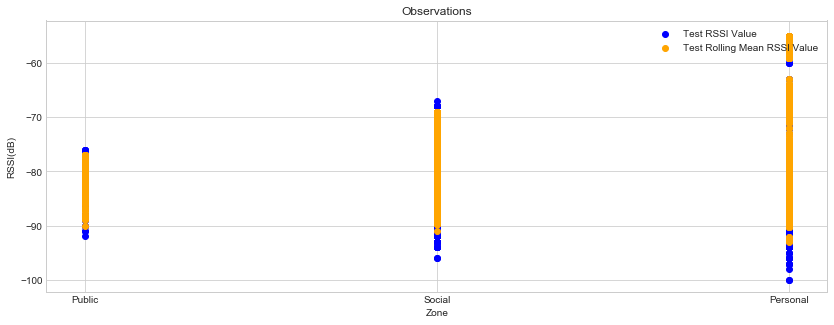

In [40]:
plt.figure(figsize=(14,5))
plt.scatter(test_dataset['zone'],test_dataset['rssi_Value'],label='Test RSSI Value',color='blue')
plt.scatter(test_dataset['zone'],test_dataset['rolling_mean_rssi'],label='Test Rolling Mean RSSI Value',color='orange')
plt.title('Observations')  
plt.xlabel('Zone')  
plt.ylabel('RSSI(dB)')  
plt.legend(loc='upper right');
plt.show()

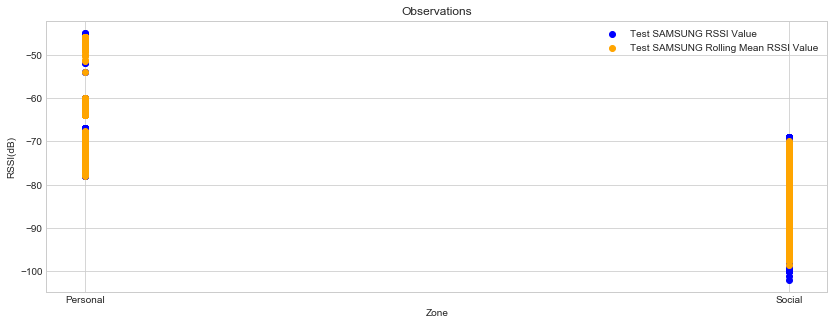

In [41]:
plt.figure(figsize=(14,5))
plt.scatter(test_dataset_home_big['zone'],test_dataset_home_big['rssi_Value'],label='Test SAMSUNG RSSI Value',color='blue')
plt.scatter(test_dataset_home_big['zone'],test_dataset_home_big['rolling_mean_rssi'],label='Test SAMSUNG Rolling Mean RSSI Value',color='orange')
plt.title('Observations')  
plt.xlabel('Zone')  
plt.ylabel('RSSI(dB)')  
plt.legend(loc='upper right');
plt.show()

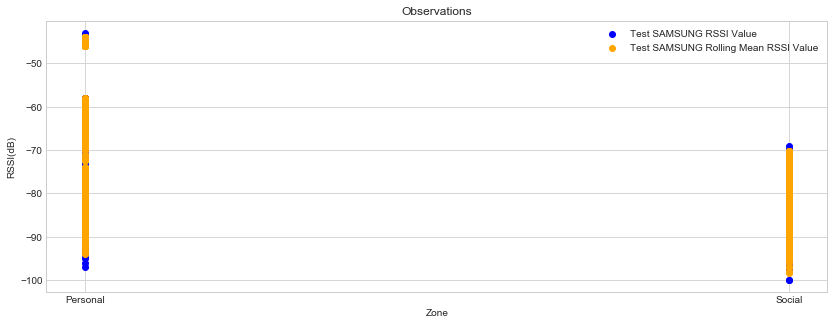

In [42]:
plt.figure(figsize=(14,5))
plt.scatter(test_dataset_home_small['zone'],test_dataset_home_small['rssi_Value'],label='Test SAMSUNG RSSI Value',color='blue')
plt.scatter(test_dataset_home_small['zone'],test_dataset_home_small['rolling_mean_rssi'],label='Test SAMSUNG Rolling Mean RSSI Value',color='orange')
plt.title('Observations')  
plt.xlabel('Zone')  
plt.ylabel('RSSI(dB)')  
plt.legend(loc='upper right');
plt.show()

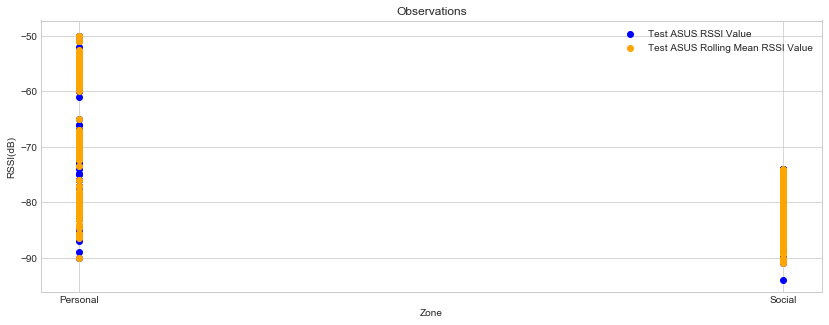

In [43]:
plt.figure(figsize=(14,5))
plt.scatter(test_dataset_home_asus['zone'],test_dataset_home_asus['rssi_Value'],label='Test ASUS RSSI Value',color='blue')
plt.scatter(test_dataset_home_asus['zone'],test_dataset_home_asus['rolling_mean_rssi'],label='Test ASUS Rolling Mean RSSI Value',color='orange')
plt.title('Observations')  
plt.xlabel('Zone')  
plt.ylabel('RSSI(dB)')  
plt.legend(loc='upper right');
plt.show()

### Initailize Hyperparameters for tunning

In [44]:
scaler = [StandardScaler(),MinMaxScaler(),MaxAbsScaler(),None]
distance_metris = ["euclidean", "manhattan", "canberra", "braycurtis"]
algorithms = ["brute","kd_tree","ball_tree","auto"]
weights = ["uniform","distance"]
knn_basic = KNeighborsClassifier()
print("DEFAULT HYPERPARAMETERS")
default_params = knn_basic.get_params()
display(pd.DataFrame(default_params,index=[1])) 

DEFAULT HYPERPARAMETERS


,algorithm,leaf_size,metric,metric_params,n_jobs,n_neighbors,p,weights
1,auto,30,minkowski,None,None,5,2,uniform


### Statistics Output Format
Structure of the statistical output of each call to the machine learning algorithm

In [45]:
def structure_data(data,precision,accuracy,f1score):
    mae = data['error'].abs().mean()
    mse = np.power(data['error'],2).mean()
    rsme = np.sqrt(mse)
    precision = precision
    accuracy = accuracy
    f1score = f1score
    statistical_results = [mae,mse,rsme,precision,accuracy,f1score]
    return statistical_results

### Feature Selection
Check strength of features using ensemble algorithm Random Forest

Feature Selection Computation


array([0.36221781, 0.63778219])

rolling_mean_rssi    0.637782
rssi_Value           0.362218
dtype: float64

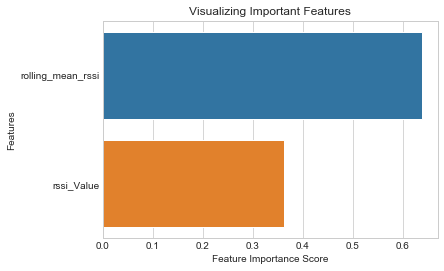

In [46]:
print("Feature Selection Computation")
random_forest_estimator = RandomForestClassifier()
main_estimator = make_pipeline(StandardScaler(),random_forest_estimator)
main_estimator.fit(combination_features_X,train_Y.ravel())
display(random_forest_estimator.feature_importances_)
feature_imp = pd.Series(random_forest_estimator.feature_importances_,index=combination_features_X.columns).sort_values(ascending=False)
display(feature_imp)
# Creating a bar plot
sns.barplot(x=feature_imp, y=feature_imp.index)
# Add labels to your graph
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")
plt.show()

### Model Training and Evaluation - KNN Classification Model

In [47]:
def compute_KNN_with_Classifier(flag=0,trainX_data = None, trainY_data = None,testX_data = None,testY_data = None, scaler = None,
                cross_validation = None,n_neighbors=5,weights='uniform', algorithm='auto', leaf_size=30, p=2, metric='minkowski',
                metric_params=None, n_jobs=-1):   
    knn_classifier_estimator = KNeighborsClassifier(n_neighbors,weights,algorithm,leaf_size,p,metric,metric_params,n_jobs)
    if scaler is not None:
        # Make pipeline using scaler transformation
        main_estimator = make_pipeline(scaler,knn_classifier_estimator)
    else:
        main_estimator = knn_classifier_estimator
    if cross_validation is None:
        # Fit the training data
        main_estimator.fit(trainX_data,trainY_data)
        # Predict the results of the testing data features
        predict_test = main_estimator.predict(testX_data) 
        matrix = confusion_matrix(testY_data, predict_test)
        report = classification_report(testY_data, predict_test,output_dict=True)
        accuracy = accuracy_score(testY_data,predict_test)
    else:
        predict_test = cross_val_predict(main_estimator,testX_data,testY_data,cv = cross_validation)
        matrix = confusion_matrix(testY_data, predict_test)
        report = classification_report(testY_data, predict_test,output_dict=True)
        accuracy = accuracy_score(testY_data,predict_test)
    statistical_array = list()
    statistics = pd.DataFrame(report).transpose()
    error_dataframe = pd.DataFrame({'Actual': testY_data.flatten(), 'Predicted':predict_test.flatten()})
    if flag == 1:
        print("Confusion Matrix:")
        print(matrix)
        display(statistics)
        display(error_dataframe)
        error_dataframe.apply(pd.value_counts).plot(kind='bar', subplots=True)
    error = pd.DataFrame(np.where(error_dataframe['Actual'] != error_dataframe['Predicted'],1,0), columns=["error"])
    result = pd.DataFrame(train_Y,columns=["zone"]).join(error)
    return structure_data(result,statistics['precision'].mean(),accuracy,statistics['f1-score'].mean())


#### Check Training model with no cross validation 
Use KNN Classifier to check the results on the training data alone

Confusion Matrix:
[[6070    0 1636]
 [1313   32 3545]
 [3250   21 8967]]


,precision,recall,f1-score,support
0,0.570864,0.787698,0.661977,7706.000000
1,0.603774,0.006544,0.012948,4890.000000
2,0.633800,0.732718,0.679679,12238.000000
accuracy,0.606789,0.606789,0.606789,0.606789
macro avg,0.602813,0.508987,0.451534,24834.000000
weighted avg,0.608359,0.606789,0.542902,24834.000000


,Actual,Predicted
0,0,0
1,0,0
2,0,0
3,0,0
4,0,0
...,...,...
24829,1,2
24830,1,2
24831,1,2
24832,1,2


Confusion Matrix:
[[5484  198 2024]
 [ 300 2439 2151]
 [1208 1517 9513]]


,precision,recall,f1-score,support
0,0.784325,0.711653,0.746224,7706.000000
1,0.587145,0.498773,0.539363,4890.000000
2,0.694988,0.777333,0.733858,12238.000000
accuracy,0.702102,0.702102,0.702102,0.702102
macro avg,0.688819,0.662586,0.673148,24834.000000
weighted avg,0.701474,0.702102,0.699398,24834.000000


,Actual,Predicted
0,0,0
1,0,0
2,0,0
3,0,0
4,0,0
...,...,...
24829,1,1
24830,1,2
24831,1,1
24832,1,1


Confusion Matrix:
[[ 6516   208   982]
 [  113  3385  1392]
 [  557  1379 10302]]


,precision,recall,f1-score,support
0,0.906763,0.845575,0.875101,7706.000000
1,0.680813,0.692229,0.686473,4890.000000
2,0.812717,0.841804,0.827005,12238.000000
accuracy,0.813522,0.813522,0.813522,0.813522
macro avg,0.800098,0.793203,0.796193,24834.000000
weighted avg,0.815927,0.813522,0.814257,24834.000000


,Actual,Predicted
0,0,0
1,0,0
2,0,0
3,0,0
4,0,0
...,...,...
24829,1,1
24830,1,1
24831,1,1
24832,1,1


,mae,mse,rmse,precision,accuracy,f1-score,type
2,0.186478,0.186478,0.431831,0.804973,0.813522,0.802092,Both
1,0.297898,0.297898,0.545800,0.693142,0.702102,0.682349,Rolling Mean RSSI
0,0.393211,0.393211,0.627065,0.604400,0.606789,0.492638,RSSI Only


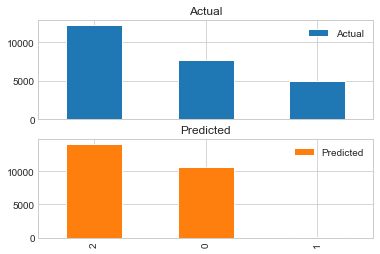

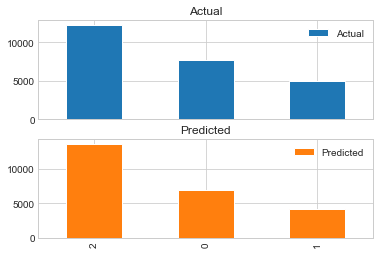

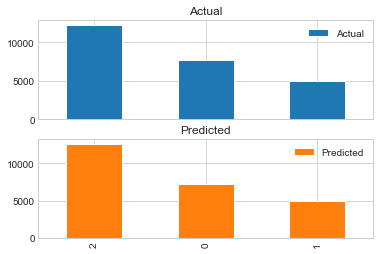

In [48]:
statistical_cols = ['mae','mse','rmse','precision','accuracy','f1-score','type']
types = ['RSSI Only','Rolling Mean RSSI','Both']
results = list()
for feature in types:
    #Decide on type of data
    if feature == 'RSSI Only':
        trainX_data = train_X_rssi
    elif feature == 'Rolling Mean RSSI':
        trainX_data = train_X_rolling_mean
    else:
        trainX_data = combination_features_X 
    result = compute_KNN_with_Classifier(flag=1,trainX_data=trainX_data,trainY_data=train_Y.ravel(),
                                   testX_data=trainX_data,testY_data=train_Y.ravel(),
                                   scaler=StandardScaler())
    result.append(feature)
    results.append(result)
statistics = pd.DataFrame(columns=statistical_cols,data=results)
display(statistics.sort_values(by=['f1-score'],ascending=False))

#### Experiment - Same amount of data per Zone

,coordinate_X,coordinate_Y,rssi_Value,rolling_mean_rssi,zone,distance,labels
0,0.0,0.0,-48,-48.0,Personal,0.0,0
1,0.0,0.0,-48,-48.0,Personal,0.0,0
2,0.0,0.0,-48,-48.0,Personal,0.0,0
3,0.0,0.0,-48,-48.0,Personal,0.0,0
4,0.0,0.0,-46,-47.6,Personal,0.0,0
...,...,...,...,...,...,...,...
14665,0.0,2.0,-73,-72.5,Social,2.0,2
14666,0.0,2.0,-74,-73.0,Social,2.0,2
14667,0.0,2.0,-73,-73.0,Social,2.0,2
14668,0.0,2.0,-73,-73.0,Social,2.0,2


(14670, 1)

(14670, 1)

(14670, 2)

(14670, 1)

Confusion Matrix:
[[3695  284  911]
 [ 317 3800  773]
 [1675  278 2937]]


,precision,recall,f1-score,support
0,0.649727,0.755624,0.698686,4890.000000
1,0.871160,0.777096,0.821444,4890.000000
2,0.635577,0.600613,0.617601,4890.000000
accuracy,0.711111,0.711111,0.711111,0.711111
macro avg,0.718821,0.711111,0.712577,14670.000000
weighted avg,0.718821,0.711111,0.712577,14670.000000


,Actual,Predicted
0,0,0
1,0,0
2,0,0
3,0,0
4,0,0
...,...,...
14665,2,2
14666,2,2
14667,2,2
14668,2,2


Confusion Matrix:
[[3777  311  802]
 [ 276 4153  461]
 [ 401  463 4026]]


,precision,recall,f1-score,support
0,0.848002,0.772393,0.808433,4890.000000
1,0.842906,0.849284,0.846083,4890.000000
2,0.761202,0.823313,0.791040,4890.000000
accuracy,0.814997,0.814997,0.814997,0.814997
macro avg,0.817370,0.814997,0.815186,14670.000000
weighted avg,0.817370,0.814997,0.815186,14670.000000


,Actual,Predicted
0,0,0
1,0,0
2,0,0
3,0,0
4,0,0
...,...,...
14665,2,2
14666,2,2
14667,2,2
14668,2,2


Confusion Matrix:
[[4217  186  487]
 [  47 4589  254]
 [ 243  319 4328]]


,precision,recall,f1-score,support
0,0.935656,0.862372,0.897520,4890.000000
1,0.900864,0.938446,0.919271,4890.000000
2,0.853817,0.885072,0.869164,4890.000000
accuracy,0.895297,0.895297,0.895297,0.895297
macro avg,0.896779,0.895297,0.895318,14670.000000
weighted avg,0.896779,0.895297,0.895318,14670.000000


,Actual,Predicted
0,0,0
1,0,0
2,0,0
3,0,0
4,0,0
...,...,...
14665,2,2
14666,2,0
14667,2,2
14668,2,2


,mae,mse,rmse,precision,accuracy,f1-score,type
2,0.104703,0.104703,0.323579,0.896532,0.895297,0.895315,Both
1,0.185003,0.185003,0.430120,0.816975,0.814997,0.815154,Rolling Mean RSSI
0,0.288889,0.288889,0.537484,0.717536,0.711111,0.712333,RSSI Only


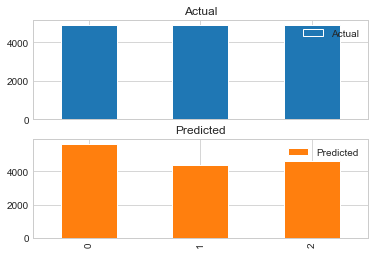

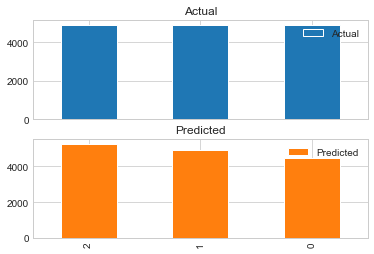

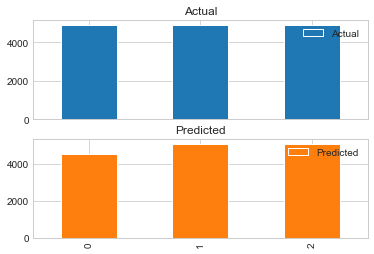

In [49]:
reference_points = dataset.groupby(['zone'])
data = list()
columns = list()
for k, rf in reference_points:
    data.append(rf.iloc[:4890].values)
    if columns is not None:
        columns = rf.columns
flat_list = []
for sublist in data:
    for item in sublist:
        flat_list.append(item)
same_amount_df = pd.DataFrame(flat_list,columns=columns)
display(same_amount_df)
train_X_rssi_same_amount = pd.DataFrame(same_amount_df['rssi_Value']).values.reshape(-1,1)
display(train_X_rssi_same_amount.shape)
train_X_rolling_mean_same_amount = pd.DataFrame(same_amount_df['rolling_mean_rssi']).values.reshape(-1,1)
display(train_X_rolling_mean_same_amount.shape)
combination_features_X_same_amount = same_amount_df[['rssi_Value','rolling_mean_rssi']]
display(combination_features_X_same_amount.shape)
train_Y_same_amount = same_amount_df['labels'].values.reshape(-1,1)
display(train_Y_same_amount.shape)
statistical_cols = ['mae','mse','rmse','precision','accuracy','f1-score','type']
types = ['RSSI Only','Rolling Mean RSSI','Both']
results = list()
for feature in types:
    #Decide on type of data
    if feature == 'RSSI Only':
        trainX_data = train_X_rssi_same_amount
    elif feature == 'Rolling Mean RSSI':
        trainX_data = train_X_rolling_mean_same_amount
    else:
        trainX_data = combination_features_X_same_amount 
    result = compute_KNN_with_Classifier(flag=1,trainX_data=trainX_data,trainY_data=train_Y_same_amount.ravel(),
                                   testX_data=trainX_data,testY_data=train_Y_same_amount.ravel(),
                                   scaler=StandardScaler())
    result.append(feature)
    results.append(result)
statistics = pd.DataFrame(columns=statistical_cols,data=results)
display(statistics.sort_values(by=['f1-score'],ascending=False))

#### Experiment - KNN with StratifiedKFold 
Experiment using cross validation approach of StratifiedKFold

,mae,mse,rmse,precision,accuracy,f1-score,folds,type
11,0.381332,0.381332,0.617521,0.608205,0.618668,0.612798,5,Both
10,0.380366,0.380366,0.616738,0.606768,0.619634,0.611150,4,Both
9,0.391198,0.391198,0.625458,0.600232,0.608802,0.602231,3,Both
3,0.434686,0.434686,0.659307,0.550134,0.565314,0.552528,5,RSSI Only
6,0.465370,0.465370,0.682180,0.520422,0.534630,0.522077,4,Rolling Mean RSSI
5,0.465451,0.465451,0.682239,0.520097,0.534549,0.519228,3,Rolling Mean RSSI
8,0.469276,0.469276,0.685037,0.511659,0.530724,0.514390,2,Both
7,0.476081,0.476081,0.689986,0.508986,0.523919,0.511122,5,Rolling Mean RSSI
0,0.502899,0.502899,0.709154,0.480976,0.497101,0.479077,2,RSSI Only
1,0.508295,0.508295,0.712948,0.470901,0.491705,0.473129,3,RSSI Only


Number of Folds:  5


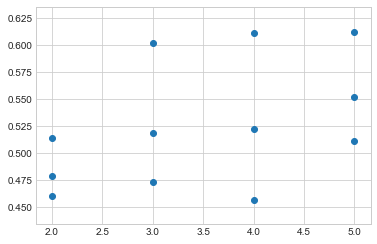

In [50]:
statistical_cols = ['mae','mse','rmse','precision','accuracy','f1-score','folds','type']
types = ['RSSI Only','Rolling Mean RSSI','Both']
cross_validation_list = np.arange(2,6)
results = list()
for feature in types:
    #Decide on type of data
    if feature == 'RSSI Only':
        trainX_data = train_X_rssi
    elif feature == 'Rolling Mean RSSI':
        trainX_data = train_X_rolling_mean
    else:
        trainX_data = combination_features_X 
    for cv in cross_validation_list:
        result = compute_KNN_with_Classifier(testX_data=trainX_data,testY_data=train_Y.ravel(),scaler=StandardScaler(),cross_validation = cv)  
        result.append(cv)
        result.append(feature)
        results.append(result)
statistics = pd.DataFrame(columns=statistical_cols,data=results)
display(statistics.sort_values(by=['f1-score'],ascending=False))
plt.scatter(statistics['folds'],statistics['f1-score'])
selected_fold = statistics.sort_values(by=['f1-score'],ascending=False)['folds'].head(1).values[0]
print("Number of Folds: ",selected_fold)

#### Experiment - KNN with HoldOut
Experiment using cross validation approach of HoldOut (Train test split)

,mae,mse,rmse,precision,accuracy,f1-score,test_size,type
22,0.232906,0.232906,0.482604,0.757925,0.767094,0.753899,0.5,Both
24,0.232685,0.232685,0.482375,0.757856,0.767315,0.753312,0.7,Both
25,0.234850,0.234850,0.484613,0.754828,0.765150,0.751409,0.8,Both
20,0.236478,0.236478,0.486290,0.752738,0.763522,0.750487,0.3,Both
21,0.235253,0.235253,0.485029,0.754293,0.764747,0.749222,0.4,Both
19,0.236360,0.236360,0.486169,0.754585,0.763640,0.748955,0.2,Both
26,0.237797,0.237797,0.487644,0.752310,0.762203,0.748610,0.9,Both
23,0.240051,0.240051,0.489950,0.748855,0.759949,0.745522,0.6,Both
18,0.243156,0.243156,0.493109,0.744643,0.756844,0.743539,0.1,Both
0,0.321659,0.321659,0.567150,0.685043,0.678341,0.673428,0.1,RSSI Only


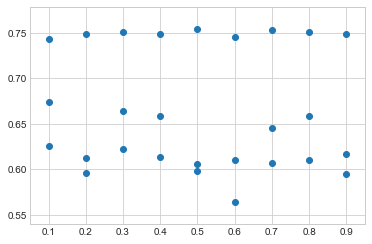

In [51]:
statistical_cols = ['mae','mse','rmse','precision','accuracy','f1-score','test_size','type']
test_sizes =[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
results = list()
types = ['RSSI Only','Rolling Mean RSSI','Both']
for feature in types:
    #Decide on type of data
    if feature == 'RSSI Only':
        trainX_data = train_X_rssi
    elif feature == 'Rolling Mean RSSI':
        trainX_data = train_X_rolling_mean
    else:
        trainX_data = combination_features_X 
    for size in test_sizes:
        X_train_split, X_test_split, y_train_split, y_test_split = train_test_split(trainX_data,train_Y.ravel(), test_size = size, random_state = 42,stratify=train_Y)
        result = compute_KNN_with_Classifier(trainX_data=X_train_split,trainY_data=y_train_split,testX_data=X_test_split,testY_data=y_test_split,scaler=StandardScaler())
        result.append(size)
        result.append(feature)
        results.append(result)
statistics = pd.DataFrame(columns=statistical_cols,data=results)
display(statistics.sort_values(by=['f1-score'],ascending=False))
plt.scatter(statistics['test_size'],statistics['f1-score'])

#### Experiment - KNN with Leave One Group Out
Experiment using cross validation approach of Leave One Group Out

In [52]:
statistical_cols = ['mae','mse','rmse','precision','accuracy','f1-score','type']
results = list()
types = ['RSSI Only','Rolling Mean RSSI','Both']
for feature in types:
    #Decide on type of data
    if feature == 'RSSI Only':
        trainX_data = train_X_rssi
    elif feature == 'Rolling Mean RSSI':
        trainX_data = train_X_rolling_mean
    else:
        trainX_data = combination_features_X 
    cv = LeaveOneGroupOut()
    splited = cv.split(trainX_data,train_Y.ravel(),groups=train_Y.ravel())
    result = compute_KNN_with_Classifier(testX_data=trainX_data,testY_data=train_Y.ravel(),scaler=StandardScaler(),cross_validation = splited)  
    result.append(feature)
    results.append(result)
statistics = pd.DataFrame(columns=statistical_cols,data=results)
display(statistics.sort_values(by=['f1-score'],ascending=False))

,mae,mse,rmse,precision,accuracy,f1-score,type
0,1.0,1.0,1.0,0.0,0.0,0.0,RSSI Only
1,1.0,1.0,1.0,0.0,0.0,0.0,Rolling Mean RSSI
2,1.0,1.0,1.0,0.0,0.0,0.0,Both


#### Evaluation Model Cross-Validation Experiment - Best cross-validation technique
Best parameters found using KNN

,mae,mse,rmse,precision,accuracy,f1-score,method,type
7,0.236478,0.236478,0.486290,0.752738,0.763522,0.750487,HoldOut,Both
1,0.314589,0.314589,0.560882,0.674683,0.685411,0.664494,HoldOut,RSSI Only
4,0.361025,0.361025,0.600854,0.629033,0.638975,0.622216,HoldOut,Rolling Mean RSSI
8,0.381332,0.381332,0.617521,0.608205,0.618668,0.612798,Stratified K-Fold,Both
2,0.434686,0.434686,0.659307,0.550134,0.565314,0.552528,Stratified K-Fold,RSSI Only
5,0.476081,0.476081,0.689986,0.508986,0.523919,0.511122,Stratified K-Fold,Rolling Mean RSSI
0,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,LOO,RSSI Only
3,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,LOO,Rolling Mean RSSI
6,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,LOO,Both


Selected cross validation method:  HoldOut


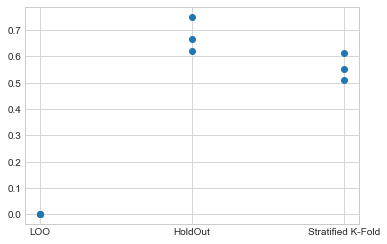

In [53]:
statistical_cols = ['mae','mse','rmse','precision','accuracy','f1-score','method','type']
types = ['RSSI Only','Rolling Mean RSSI','Both']
results = list()
for feature in types:
    #Decide on type of data
    if feature == 'RSSI Only':
        trainX_data = train_X_rssi
    elif feature == 'Rolling Mean RSSI':
        trainX_data = train_X_rolling_mean
    else:
        trainX_data = combination_features_X 
    X_train_split, X_test_split, y_train_split, y_test_split = train_test_split(trainX_data,train_Y.ravel(), test_size = 0.3, random_state = 42,stratify=train_Y)
    holdout = compute_KNN_with_Classifier(trainX_data=X_train_split,trainY_data=y_train_split,testX_data=X_test_split,testY_data=y_test_split,scaler=StandardScaler())
    cv = LeaveOneGroupOut()
    splited = cv.split(trainX_data,train_Y.ravel(),groups=train_Y.ravel())
    loo = compute_KNN_with_Classifier(testX_data=trainX_data,testY_data=train_Y.ravel(),scaler=StandardScaler(),cross_validation = splited)  
    loo.append('LOO')
    loo.append(feature)
    results.append(loo)
    holdout.append('HoldOut')
    holdout.append(feature)
    results.append(holdout)
    skfold = compute_KNN_with_Classifier(testX_data=trainX_data,testY_data=train_Y.ravel(),scaler=StandardScaler(),cross_validation = selected_fold)
    skfold.append('Stratified K-Fold')
    skfold.append(feature)
    results.append(skfold)
statistics = pd.DataFrame(columns=statistical_cols,data=results)
display(statistics.sort_values(by=['f1-score'],ascending=False))
plt.plot(statistics['method'],statistics['f1-score'],'o')
selected_method = statistics.sort_values(by=['f1-score'],ascending=False)['method'].head(1).values[0]
print("Selected cross validation method: ",selected_method)

#### Experiment - Best preprocessing technique
Experiment with the different preprocessing techniques

,mae,mse,rmse,precision,accuracy,f1-score,preprocessing,preprocessingFunc,type
8,0.236478,0.236478,0.486290,0.752738,0.763522,0.750487,StandardScaler,"StandardScaler(copy=True, with_mean=True, with...",Both
11,0.238760,0.238760,0.488631,0.750285,0.761240,0.748900,None,None,Both
9,0.239699,0.239699,0.489591,0.749192,0.760301,0.747230,MinMaxScaler,"MinMaxScaler(copy=True, feature_range=(0, 1))",Both
10,0.239565,0.239565,0.489454,0.749323,0.760435,0.747207,MaxAbsScaler,MaxAbsScaler(copy=True),Both
0,0.314589,0.314589,0.560882,0.674683,0.685411,0.664494,StandardScaler,"StandardScaler(copy=True, with_mean=True, with...",RSSI Only
1,0.314589,0.314589,0.560882,0.674683,0.685411,0.664494,MinMaxScaler,"MinMaxScaler(copy=True, feature_range=(0, 1))",RSSI Only
2,0.314589,0.314589,0.560882,0.674683,0.685411,0.664494,MaxAbsScaler,MaxAbsScaler(copy=True),RSSI Only
3,0.314589,0.314589,0.560882,0.674683,0.685411,0.664494,None,None,RSSI Only
4,0.361025,0.361025,0.600854,0.629033,0.638975,0.622216,StandardScaler,"StandardScaler(copy=True, with_mean=True, with...",Rolling Mean RSSI
5,0.361025,0.361025,0.600854,0.629033,0.638975,0.622216,MinMaxScaler,"MinMaxScaler(copy=True, feature_range=(0, 1))",Rolling Mean RSSI


Selected Preprocessing:  StandardScaler


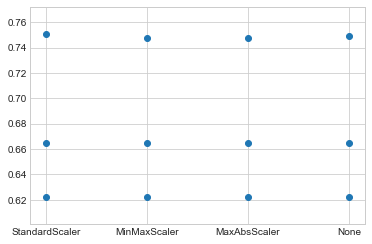

In [54]:
statistical_cols = ['mae','mse','rmse','precision','accuracy','f1-score','preprocessing','preprocessingFunc','type']
types = ['RSSI Only','Rolling Mean RSSI','Both']
results = list()
for feature in types:
    #Decide on type of data
    if feature == 'RSSI Only':
        trainX_data = train_X_rssi
    elif feature == 'Rolling Mean RSSI':
        trainX_data = train_X_rolling_mean
    else:
        trainX_data = combination_features_X 
    for preprocess in scaler:
        if selected_method == 'LOO':
            cv = LeaveOneGroupOut()
            splited = cv.split(trainX_data,train_Y.ravel(),groups=train_Y.ravel())
            result = compute_KNN_with_Classifier(testX_data=trainX_data,testY_data=train_Y.ravel(),scaler=preprocess,cross_validation = splited)  
        elif selected_method =='Stratified K-Fold':
            result = compute_KNN_with_Classifier(testX_data=trainX_data,testY_data=train_Y.ravel(),scaler=preprocess,cross_validation = selected_fold)
        else:
            X_train_split, X_test_split, y_train_split, y_test_split = train_test_split(trainX_data,train_Y.ravel(), test_size = 0.3, random_state = 42,stratify=train_Y)
            result = compute_KNN_with_Classifier(trainX_data=X_train_split,trainY_data=y_train_split,testX_data=X_test_split,testY_data=y_test_split,scaler=preprocess)
        if(preprocess is None):
            regex = 'None'
        else:
            regex = re.search('(\w+)\(',str(preprocess)).group(1)
        result.append(regex)
        result.append(preprocess)
        result.append(feature)
        results.append(result)
statistics = pd.DataFrame(columns=statistical_cols,data=results)
display(statistics.sort_values(by=['f1-score'],ascending=False))
plt.scatter(statistics['preprocessing'],statistics['f1-score'])
selected_preprocessing = statistics.sort_values(by=['f1-score'],ascending=False)['preprocessing'].head(1).values[0]
selected_preprocesssing_func = statistics.sort_values(by=['f1-score'],ascending=False)['preprocessingFunc'].head(1).values[0]
print("Selected Preprocessing: ",selected_preprocessing)

#### Experiment -  Running the KNN function with the different weights

,mae,mse,rmse,precision,accuracy,f1-score,weights,type
4,0.236478,0.236478,0.486290,0.752738,0.763522,0.750487,uniform,Both
5,0.253389,0.253389,0.503377,0.734780,0.746611,0.733369,distance,Both
0,0.314589,0.314589,0.560882,0.674683,0.685411,0.664494,uniform,RSSI Only
1,0.314589,0.314589,0.560882,0.674683,0.685411,0.664494,distance,RSSI Only
2,0.361025,0.361025,0.600854,0.629033,0.638975,0.622216,uniform,Rolling Mean RSSI
3,0.372702,0.372702,0.610493,0.615498,0.627298,0.613388,distance,Rolling Mean RSSI


Selected weight:  uniform


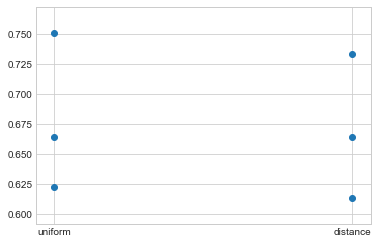

In [55]:
statistical_cols = ['mae','mse','rmse','precision','accuracy','f1-score','weights','type']
results = list()
types = ['RSSI Only','Rolling Mean RSSI','Both']
for feature in types:
    #Decide on type of data
    if feature == 'RSSI Only':
        trainX_data = train_X_rssi
    elif feature == 'Rolling Mean RSSI':
        trainX_data = train_X_rolling_mean
    else:
        trainX_data = combination_features_X 
    for weight in weights:
        if selected_method == 'LOO':
            cv = LeaveOneGroupOut()
            splited = cv.split(trainX_data,train_Y.ravel(),groups=train_Y.ravel())
            result = compute_KNN_with_Classifier(testX_data=trainX_data,testY_data=train_Y.ravel(),scaler=StandardScaler(),cross_validation = splited,
                                               weights = weight)  
        elif selected_method =='Stratified K-Fold':
            result = compute_KNN_with_Classifier(testX_data=trainX_data,testY_data=train_Y.ravel(),scaler=StandardScaler(),cross_validation = selected_fold,
                                weights = weight)
        else:
            X_train_split, X_test_split, y_train_split, y_test_split = train_test_split(trainX_data,train_Y.ravel(), test_size = 0.3, random_state = 42,stratify=train_Y)
            result = compute_KNN_with_Classifier(trainX_data=X_train_split,trainY_data=y_train_split,testX_data=X_test_split,testY_data=y_test_split,
                                                 scaler=StandardScaler(),
                                               weights = weight)
        result.append(weight)
        result.append(feature)
        results.append(result)
statistics = pd.DataFrame(columns=statistical_cols,data=results)
display(statistics.sort_values(by=['f1-score'],ascending=False))
plt.scatter(statistics['weights'],statistics['f1-score'])
selected_weight = statistics.sort_values(by=['f1-score'],ascending=False)['weights'].head(1).values[0]
print("Selected weight: ",selected_weight)

#### Experiment - Running the KNN function with the different algorithms

,mae,mse,rmse,precision,accuracy,f1-score,algorithm,type
10,0.236076,0.236076,0.485876,0.753322,0.763924,0.751057,ball_tree,Both
9,0.236478,0.236478,0.486290,0.752738,0.763522,0.750487,kd_tree,Both
11,0.236478,0.236478,0.486290,0.752738,0.763522,0.750487,auto,Both
8,0.237015,0.237015,0.486842,0.751667,0.762985,0.749185,brute,Both
1,0.314589,0.314589,0.560882,0.674683,0.685411,0.664494,kd_tree,RSSI Only
2,0.314589,0.314589,0.560882,0.674683,0.685411,0.664494,ball_tree,RSSI Only
3,0.314589,0.314589,0.560882,0.674683,0.685411,0.664494,auto,RSSI Only
0,0.344786,0.344786,0.587185,0.659254,0.655214,0.630352,brute,RSSI Only
5,0.361025,0.361025,0.600854,0.629033,0.638975,0.622216,kd_tree,Rolling Mean RSSI
7,0.361025,0.361025,0.600854,0.629033,0.638975,0.622216,auto,Rolling Mean RSSI


Selected algorithm:  ball_tree


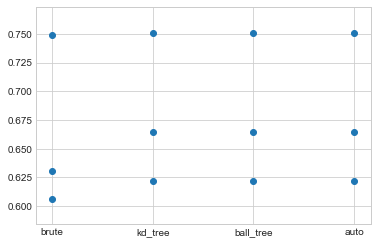

In [56]:
statistical_cols = ['mae','mse','rmse','precision','accuracy','f1-score','algorithm','type']
results = list()
types = ['RSSI Only','Rolling Mean RSSI','Both']
for feature in types:
    #Decide on type of data
    if feature == 'RSSI Only':
        trainX_data = train_X_rssi
    elif feature == 'Rolling Mean RSSI':
        trainX_data = train_X_rolling_mean
    else:
        trainX_data = combination_features_X 
    for algorithm in algorithms:
        if selected_method == 'LOO':
            cv = LeaveOneGroupOut()
            splited = cv.split(trainX_data,Y_train.ravel(),groups=Y_train.ravel())
            result = compute_KNN_with_Classifier(testX_data=trainX_data,testY_data=train_Y.ravel(),scaler=StandardScaler(),cross_validation = splited,
                                               algorithm= algorithm)  
        elif selected_method =='Stratified K-Fold':
            result = compute_KNN_with_Classifier(testX_data=trainX_data,testY_data=train_Y.ravel(),scaler=StandardScaler(),cross_validation = selected_fold,
                                algorithm= algorithm)
        else:
            X_train_split, X_test_split, y_train_split, y_test_split = train_test_split(trainX_data,train_Y.ravel(), test_size = 0.3, random_state = 42,stratify=train_Y)
            result = compute_KNN_with_Classifier(trainX_data=X_train_split,trainY_data=y_train_split,testX_data=X_test_split,testY_data=y_test_split,
                                                 scaler=StandardScaler(),
                                               algorithm= algorithm)
        result.append(algorithm)
        result.append(feature)
        results.append(result)
statistics = pd.DataFrame(columns=statistical_cols,data=results)
display(statistics.sort_values(by=['f1-score'],ascending=False))
plt.scatter(statistics['algorithm'],statistics['f1-score'])
selected_algorithm = statistics.sort_values(by=['f1-score'],ascending=False)['algorithm'].head(1).values[0]
print("Selected algorithm: ",selected_algorithm)

#### Experiment - Running the KNN function with the different distance metrics

,mae,mse,rmse,precision,accuracy,f1-score,distance,type
11,0.235941,0.235941,0.485738,0.753385,0.764059,0.751230,braycurtis,Both
10,0.236210,0.236210,0.486014,0.753038,0.763790,0.750843,canberra,Both
9,0.236344,0.236344,0.486152,0.752882,0.763656,0.750612,manhattan,Both
8,0.236478,0.236478,0.486290,0.752738,0.763522,0.750487,euclidean,Both
0,0.314589,0.314589,0.560882,0.674683,0.685411,0.664494,euclidean,RSSI Only
1,0.314589,0.314589,0.560882,0.674683,0.685411,0.664494,manhattan,RSSI Only
2,0.314723,0.314723,0.561002,0.674520,0.685277,0.664303,canberra,RSSI Only
3,0.314723,0.314723,0.561002,0.674520,0.685277,0.664303,braycurtis,RSSI Only
4,0.361025,0.361025,0.600854,0.629033,0.638975,0.622216,euclidean,Rolling Mean RSSI
5,0.361025,0.361025,0.600854,0.629033,0.638975,0.622216,manhattan,Rolling Mean RSSI


Selected distance:  braycurtis


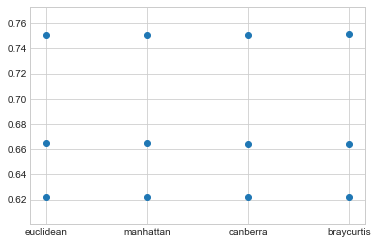

In [57]:
statistical_cols = ['mae','mse','rmse','precision','accuracy','f1-score','distance','type']
results = list()
types = ['RSSI Only','Rolling Mean RSSI','Both']
for feature in types:
    #Decide on type of data
    if feature == 'RSSI Only':
        trainX_data = train_X_rssi
    elif feature == 'Rolling Mean RSSI':
        trainX_data = train_X_rolling_mean
    else:
        trainX_data = combination_features_X 
    for distance in distance_metris:
        if selected_method == 'LOO':
            cv = LeaveOneGroupOut()
            splited = cv.split(trainX_data,train_Y.ravel,groups=train_Y.ravel())
            result = compute_KNN_with_Classifier(testX_data=trainX_data,testY_data=train_Y.ravel(),scaler=StandardScaler(),cross_validation = splited,
                                               metric = distance)  
        elif selected_method =='Stratified K-Fold':
            result = compute_KNN_with_Classifier(testX_data=trainX_data,testY_data=train_Y.ravel(),scaler=StandardScaler(),cross_validation = selected_fold,
                                metric = distance)
        else:
            X_train_split, X_test_split, y_train_split, y_test_split = train_test_split(trainX_data,train_Y.ravel(), test_size = 0.3, random_state = 42,stratify=train_Y)
            result = compute_KNN_with_Classifier(trainX_data=X_train_split,trainY_data=y_train_split,testX_data=X_test_split,testY_data=y_test_split,
                                                 scaler=StandardScaler(),
                                               metric = distance)
        result.append(distance)
        result.append(feature)
        results.append(result)
statistics = pd.DataFrame(columns=statistical_cols,data=results)
display(statistics.sort_values(by=['f1-score'],ascending=False))
plt.scatter(statistics['distance'],statistics['f1-score'])
selected_distance = statistics.sort_values(by=['f1-score'],ascending=False)['distance'].head(1).values[0]
print("Selected distance: ",selected_distance)

#### Experiment - Tuning the K parameter

{'knn__n_neighbors': 24}
Max accuracy:  0.5950301064755943
{'knn__n_neighbors': 1}
Max accuracy:  0.5440887221752977
{'knn__n_neighbors': 13}
Max accuracy:  0.632114355065624


,n_neighbhors,type
0,24,RSSI Only
1,1,Rolling Mean RSSI
2,13,Both


Text(0, 0.5, 'Cross-validated accuracy')

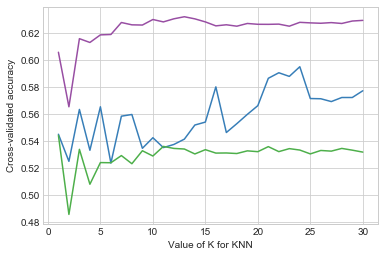

In [58]:
statistical_cols = ['n_neighbhors','type']
types = ['RSSI Only','Rolling Mean RSSI','Both']
results = list()
num = 0
palette = plt.get_cmap('Set1')
grid_results = list()
k_range = list(range(1, 31))
for feature in types:
    #Decide on type of data
    if feature == 'RSSI Only':
        trainX_data = train_X_rssi
    elif feature == 'Rolling Mean RSSI':
        trainX_data = train_X_rolling_mean
    else:
        trainX_data = combination_features_X 
    result = list()
    knn_classifier_estimator = KNeighborsClassifier() #init knn regressor estimator
    param_grid = {'knn__n_neighbors': k_range}
    # Create a pipeline
    pipe = Pipeline([('standardizer', StandardScaler()), ('knn', knn_classifier_estimator)])
    estimator = GridSearchCV(pipe, param_grid,cv=selected_fold)
    #fit model to data
    estimator.fit(trainX_data,train_Y.ravel())
    print(estimator.best_params_)
    grid_mean_scores = estimator.cv_results_['mean_test_score']
    print('Max accuracy: ', max(grid_mean_scores))
    grid_result = [grid_mean_scores]
    result.append(estimator.best_params_['knn__n_neighbors'])
    result.append(feature)
    results.append(result)
    grid_results.append(grid_result)
statistics = pd.DataFrame(columns=statistical_cols,data=results)
display(statistics)
for grid in grid_results:
    num+=1
    plt.plot(k_range, grid[0],color=palette(num))
plt.xlabel('Value of K for KNN')
plt.ylabel('Cross-validated accuracy')

### Run RandomizedSearchCV for parameter tunning

In [59]:
types = ['RSSI Only','Rolling Mean RSSI','Both']
results = list()
num = 0
palette = plt.get_cmap('Set1')
grid_results = list()
k_range = list(range(1, 31))
tuned_parameters = {
    'knn__n_neighbors': k_range,
    'knn__metric':distance_metris,
    'knn__weights':weights
}
scores = ['f1_macro']
for score in scores:
    print("# Tuning hyper-parameters for %s" % score)
    print()
    for feature in types:
        #Decide on type of data
        if feature == 'RSSI Only':
            trainX_data = train_X_rssi
        elif feature == 'Rolling Mean RSSI':
            trainX_data = train_X_rolling_mean
        else:
            trainX_data = combination_features_X 
        pipe = Pipeline([('standardizer', StandardScaler()), ('knn', KNeighborsClassifier())])
        clf = RandomizedSearchCV(pipe, tuned_parameters,n_iter=75,cv=selected_fold,scoring=score,verbose=1
        )
        clf.fit(trainX_data,train_Y.ravel())
        clf.best_params_['score'] = score
        clf.best_params_['best_score'] = clf.best_score_
        clf.best_params_['type'] = feature
        results.append(clf.best_params_)
gridcv_results = pd.DataFrame(results).sort_values(by=['best_score'],ascending=False)
display(gridcv_results)

# Tuning hyper-parameters for f1_macro

Fitting 5 folds for each of 75 candidates, totalling 375 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 375 out of 375 | elapsed:  1.2min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 5 folds for each of 75 candidates, totalling 375 fits


[Parallel(n_jobs=1)]: Done 375 out of 375 | elapsed:   46.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 5 folds for each of 75 candidates, totalling 375 fits


[Parallel(n_jobs=1)]: Done 375 out of 375 | elapsed:  1.1min finished


,knn__weights,knn__n_neighbors,knn__metric,score,best_score,type
2,uniform,12,manhattan,f1_macro,0.624769,Both
0,distance,3,braycurtis,f1_macro,0.554580,RSSI Only
1,uniform,1,euclidean,f1_macro,0.524357,Rolling Mean RSSI


### Best Parameters
Display the best parameters tunned throughout the experiments

In [60]:
conclusion_cols=['K Parameter','Cross Validation','Weight','Preprocessing','Algorithm','Distance']
conclusion_list = [12,selected_method,selected_weight,selected_preprocessing,selected_algorithm,selected_distance]
conclusion_pd = pd.DataFrame([conclusion_list],columns= conclusion_cols)
display(conclusion_pd)

,K Parameter,Cross Validation,Weight,Preprocessing,Algorithm,Distance
0,12,HoldOut,uniform,StandardScaler,ball_tree,braycurtis


### Best Results
Compute KNN with the best parameters in both RSSI and Rolling Mean

Confusion Matrix:
[[1622   99  591]
 [  36  758  673]
 [ 175  496 3001]]


,precision,recall,f1-score,support
0,0.884888,0.701557,0.782630,2312.000000
1,0.560237,0.516701,0.537589,1467.000000
2,0.703634,0.817266,0.756205,3672.000000
accuracy,0.722185,0.722185,0.722185,0.722185
macro avg,0.716253,0.678508,0.692141,7451.000000
weighted avg,0.731643,0.722185,0.721362,7451.000000


,Actual,Predicted
0,2,2
1,2,2
2,1,1
3,2,2
4,2,2
...,...,...
7446,1,2
7447,0,0
7448,2,2
7449,0,0


Confusion Matrix:
[[1587   49  676]
 [  46  672  749]
 [ 400  591 2681]]


,precision,recall,f1-score,support
0,0.780620,0.686419,0.730495,2312.000000
1,0.512195,0.458078,0.483627,1467.000000
2,0.652947,0.730120,0.689380,3672.000000
accuracy,0.662998,0.662998,0.662998,0.662998
macro avg,0.648587,0.624872,0.634501,7451.000000
weighted avg,0.664851,0.662998,0.661628,7451.000000


,Actual,Predicted
0,2,2
1,2,2
2,1,2
3,2,2
4,2,2
...,...,...
7446,1,2
7447,0,0
7448,2,0
7449,0,0


Confusion Matrix:
[[1899   57  356]
 [  32  957  478]
 [ 243  502 2927]]


,precision,recall,f1-score,support
0,0.873505,0.821367,0.846634,2312.000000
1,0.631266,0.652352,0.641636,1467.000000
2,0.778250,0.797113,0.787569,3672.000000
accuracy,0.776137,0.776137,0.776137,0.776137
macro avg,0.761007,0.756944,0.758613,7451.000000
weighted avg,0.778868,0.776137,0.777164,7451.000000


,Actual,Predicted
0,2,2
1,2,2
2,1,1
3,2,2
4,2,2
...,...,...
7446,1,2
7447,0,0
7448,2,2
7449,0,0


,mae,mse,rmse,precision,accuracy,f1-score,type
2,0.223863,0.223863,0.473141,0.766506,0.776137,0.764626,Both
0,0.277815,0.277815,0.527082,0.719807,0.722185,0.702019,RSSI Only
1,0.337002,0.337002,0.580519,0.653700,0.662998,0.643772,Rolling Mean RSSI


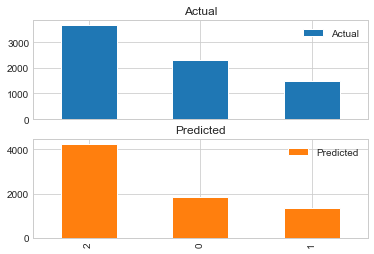

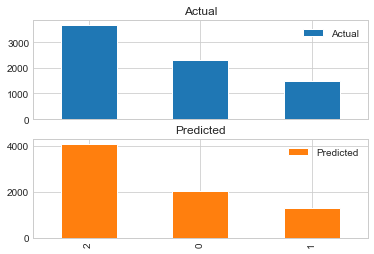

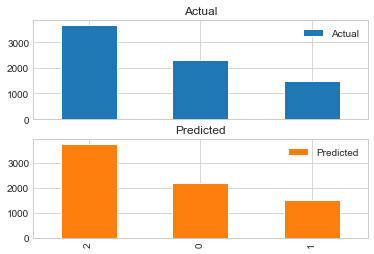

In [81]:
statistical_cols = ['mae','mse','rmse','precision','accuracy','f1-score','type']
results = list()
final_results = list()
types = ['RSSI Only','Rolling Mean RSSI','Both']
for feature in types:
    #Decide on type of data
    if feature == 'RSSI Only':
        trainX_data = train_X_rssi
    elif feature == 'Rolling Mean RSSI':
        trainX_data = train_X_rolling_mean
    else:
        trainX_data = combination_features_X 
    if selected_method == 'LOO':
        cv = LeaveOneGroupOut()
        splited = cv.split(trainX_data,train_Y.ravel(),groups=train_Y.ravel())
        result = compute_KNN_with_Classifier(flag=1,n_neighbors=12,testX_data=trainX_data,testY_data=train_Y.ravel(),scaler=StandardScaler(),cross_validation = splited,
                            metric=selected_distance,
                             weights=selected_weight)  
    elif selected_method =='Stratified K-Fold':
        result = compute_KNN_with_Classifier(flag=1,n_neighbors=12,testX_data=trainX_data,testY_data=train_Y.ravel(),scaler=StandardScaler(),
                                             cross_validation = selected_fold,
                            metric=selected_distance,
                             weights=selected_weight)  
    else:
        X_train_split, X_test_split, y_train_split, y_test_split = train_test_split(trainX_data,train_Y.ravel(), test_size = 0.3, random_state = 42,stratify=train_Y)
        result = compute_KNN_with_Classifier(flag=1,n_neighbors=12,trainX_data=X_train_split,trainY_data=y_train_split,testX_data=X_test_split,testY_data=y_test_split,
                             scaler=StandardScaler(),metric=selected_distance,
                             weights=selected_weight)  
    result.append(feature)
    results.append(result)
statistics = pd.DataFrame(columns=statistical_cols,data=results)
display(statistics.sort_values(by=['f1-score'],ascending=False))
final_results.append(statistics.sort_values(by=['f1-score'],ascending=False).head(1).values[0])

### Best Results - Same Amount of Data
Compute KNN with the best parameters in both RSSI and Rolling Mean

,coordinate_X,coordinate_Y,rssi_Value,rolling_mean_rssi,zone,distance,labels
0,0.0,0.0,-48,-48.0,Personal,0.0,0
1,0.0,0.0,-48,-48.0,Personal,0.0,0
2,0.0,0.0,-48,-48.0,Personal,0.0,0
3,0.0,0.0,-48,-48.0,Personal,0.0,0
4,0.0,0.0,-46,-47.6,Personal,0.0,0
...,...,...,...,...,...,...,...
14665,0.0,2.0,-73,-72.5,Social,2.0,2
14666,0.0,2.0,-74,-73.0,Social,2.0,2
14667,0.0,2.0,-73,-73.0,Social,2.0,2
14668,0.0,2.0,-73,-73.0,Social,2.0,2


(14670, 1)

(14670, 1)

(14670, 2)

(14670, 1)

Confusion Matrix:
[[1067  148  252]
 [   0 1280  187]
 [  71  249 1147]]


,precision,recall,f1-score,support
0,0.937610,0.727335,0.819194,1467.00000
1,0.763268,0.872529,0.814249,1467.00000
2,0.723203,0.781868,0.751392,1467.00000
accuracy,0.793910,0.793910,0.793910,0.79391
macro avg,0.808027,0.793910,0.794945,4401.00000
weighted avg,0.808027,0.793910,0.794945,4401.00000


,Actual,Predicted
0,2,2
1,1,2
2,1,1
3,1,1
4,1,2
...,...,...
4396,2,2
4397,0,0
4398,2,1
4399,2,2


Confusion Matrix:
[[1020  113  334]
 [  65 1226  176]
 [ 153  173 1141]]


,precision,recall,f1-score,support
0,0.823910,0.695297,0.754159,1467.000000
1,0.810847,0.835719,0.823095,1467.000000
2,0.691096,0.777778,0.731879,1467.000000
accuracy,0.769598,0.769598,0.769598,0.769598
macro avg,0.775284,0.769598,0.769711,4401.000000
weighted avg,0.775284,0.769598,0.769711,4401.000000


,Actual,Predicted
0,2,2
1,1,2
2,1,1
3,1,1
4,1,1
...,...,...
4396,2,2
4397,0,0
4398,2,1
4399,2,0


Confusion Matrix:
[[1206   70  191]
 [   8 1352  107]
 [ 124   76 1267]]


,precision,recall,f1-score,support
0,0.901345,0.822086,0.859893,1467.000000
1,0.902537,0.921609,0.911973,1467.000000
2,0.809585,0.863667,0.835752,1467.000000
accuracy,0.869121,0.869121,0.869121,0.869121
macro avg,0.871156,0.869121,0.869206,4401.000000
weighted avg,0.871156,0.869121,0.869206,4401.000000


,Actual,Predicted
0,2,2
1,1,2
2,1,1
3,1,1
4,1,1
...,...,...
4396,2,2
4397,0,0
4398,2,2
4399,2,2


,mae,mse,rmse,precision,accuracy,f1-score,type
2,0.130879,0.130879,0.361773,0.870816,0.869121,0.869192,Both
0,0.206090,0.206090,0.453971,0.805674,0.793910,0.794773,RSSI Only
1,0.230402,0.230402,0.480002,0.774336,0.769598,0.769692,Rolling Mean RSSI


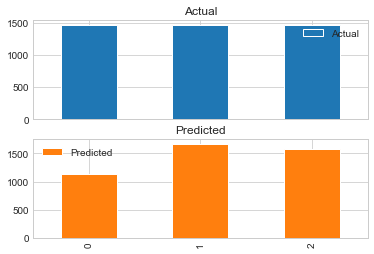

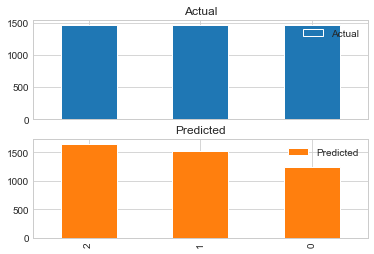

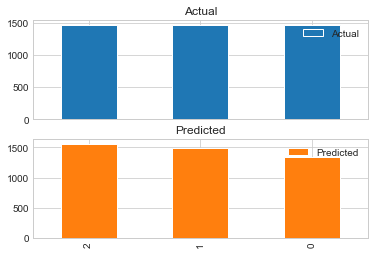

In [82]:
reference_points = dataset.groupby(['zone'])
data = list()
columns = list()
results = list()
for k, rf in reference_points:
    data.append(rf.iloc[:4890].values)
    if columns is not None:
        columns = rf.columns
flat_list = []
for sublist in data:
    for item in sublist:
        flat_list.append(item)
same_amount_df = pd.DataFrame(flat_list,columns=columns)
display(same_amount_df)
train_X_rssi_same_amount = pd.DataFrame(same_amount_df['rssi_Value']).values.reshape(-1,1)
display(train_X_rssi_same_amount.shape)
train_X_rolling_mean_same_amount = pd.DataFrame(same_amount_df['rolling_mean_rssi']).values.reshape(-1,1)
display(train_X_rolling_mean_same_amount.shape)
combination_features_X_same_amount = same_amount_df[['rssi_Value','rolling_mean_rssi']]
display(combination_features_X_same_amount.shape)
train_Y_same_amount = same_amount_df['labels'].values.reshape(-1,1)
display(train_Y_same_amount.shape)
types = ['RSSI Only','Rolling Mean RSSI','Both']
for feature in types:
    #Decide on type of data
    if feature == 'RSSI Only':
        trainX_data = train_X_rssi_same_amount
    elif feature == 'Rolling Mean RSSI':
        trainX_data = train_X_rolling_mean_same_amount
    else:
        trainX_data = combination_features_X_same_amount
    if selected_method == 'LOO':
        cv = LeaveOneGroupOut()
        splited = cv.split(trainX_data,train_Y.ravel(),groups=train_Y.ravel())
        result = compute_KNN_with_Classifier(flag=1,n_neighbors=12,testX_data=trainX_data,testY_data=train_Y_same_amount.ravel(),scaler=StandardScaler(),cross_validation = splited,
                            metric=selected_distance,
                             weights=selected_weight)  
    elif selected_method =='Stratified K-Fold':
        result = compute_KNN_with_Classifier(flag=1,n_neighbors=12,testX_data=trainX_data,testY_data=train_Y_same_amount.ravel(),scaler=StandardScaler(),
                                             cross_validation = selected_fold,
                            metric=selected_distance,
                             weights=selected_weight)  
    else:
        X_train_split, X_test_split, y_train_split, y_test_split = train_test_split(trainX_data,train_Y_same_amount.ravel(), test_size = 0.3, random_state = 42,stratify=train_Y_same_amount)
        result = compute_KNN_with_Classifier(flag=1,n_neighbors=12,trainX_data=X_train_split,trainY_data=y_train_split,testX_data=X_test_split,testY_data=y_test_split,
                             scaler=StandardScaler(),metric=selected_distance,
                             weights=selected_weight)  
    result.append(feature)
    results.append(result)
statistics = pd.DataFrame(columns=statistical_cols,data=results)
display(statistics.sort_values(by=['f1-score'],ascending=False))
final_results.append(statistics.sort_values(by=['f1-score'],ascending=False).head(1).values[0])

### Best Results - Testing data (Different Beacon)
Experiment with testing dataset

Confusion Matrix:
[[ 999   27   85]
 [ 105    4  602]
 [ 476   35 1344]]


,precision,recall,f1-score,support
0,0.632278,0.899190,0.742475,1111.000000
1,0.060606,0.005626,0.010296,711.000000
2,0.661743,0.724528,0.691714,1855.000000
accuracy,0.638292,0.638292,0.638292,0.638292
macro avg,0.451543,0.543115,0.481495,3677.000000
weighted avg,0.536602,0.638292,0.575289,3677.000000


,Actual,Predicted
0,1,2
1,1,2
2,1,2
3,1,2
4,1,2
...,...,...
3672,0,0
3673,0,0
3674,0,0
3675,0,0


Confusion Matrix:
[[   0    0 1111]
 [   0    0  711]
 [   0    0 1855]]


D:\Programs\Anaconda\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,precision,recall,f1-score,support
0,0.000000,0.000000,0.000000,1111.000000
1,0.000000,0.000000,0.000000,711.000000
2,0.504487,1.000000,0.670644,1855.000000
accuracy,0.504487,0.504487,0.504487,0.504487
macro avg,0.168162,0.333333,0.223548,3677.000000
weighted avg,0.254507,0.504487,0.338331,3677.000000


,Actual,Predicted
0,1,2
1,1,2
2,1,2
3,1,2
4,1,2
...,...,...
3672,0,2
3673,0,2
3674,0,2
3675,0,2


Confusion Matrix:
[[ 954   58   99]
 [  43  106  562]
 [ 535  166 1154]]


,precision,recall,f1-score,support
0,0.622715,0.858686,0.721907,1111.000000
1,0.321212,0.149086,0.203650,711.000000
2,0.635813,0.622102,0.628883,1855.000000
accuracy,0.602121,0.602121,0.602121,0.602121
macro avg,0.526580,0.543291,0.518147,3677.000000
weighted avg,0.571023,0.602121,0.574765,3677.000000


,Actual,Predicted
0,1,2
1,1,2
2,1,2
3,1,2
4,1,2
...,...,...
3672,0,0
3673,0,0
3674,0,0
3675,0,0


Confusion Matrix:
[[   0 1111    0]
 [   0  711    0]
 [   0 1855    0]]


D:\Programs\Anaconda\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,precision,recall,f1-score,support
0,0.000000,0.000000,0.000000,1111.000000
1,0.193364,1.000000,0.324066,711.000000
2,0.000000,0.000000,0.000000,1855.000000
accuracy,0.193364,0.193364,0.193364,0.193364
macro avg,0.064455,0.333333,0.108022,3677.000000
weighted avg,0.037390,0.193364,0.062663,3677.000000


,Actual,Predicted
0,1,1
1,1,1
2,1,1
3,1,1
4,1,1
...,...,...
3672,0,1
3673,0,1
3674,0,1
3675,0,1


Confusion Matrix:
[[995  61  55]
 [ 97 115 499]
 [653 251 951]]


,precision,recall,f1-score,support
0,0.570201,0.895590,0.696779,1111.000000
1,0.269321,0.161744,0.202109,711.000000
2,0.631894,0.512668,0.566071,1855.000000
accuracy,0.560511,0.560511,0.560511,0.560511
macro avg,0.490472,0.523334,0.488320,3677.000000
weighted avg,0.543145,0.560511,0.535187,3677.000000


,Actual,Predicted
0,1,2
1,1,1
2,1,2
3,1,1
4,1,1
...,...,...
3672,0,0
3673,0,0
3674,0,0
3675,0,0


Confusion Matrix:
[[   0 1111    0]
 [   0  711    0]
 [   0 1855    0]]


D:\Programs\Anaconda\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,precision,recall,f1-score,support
0,0.000000,0.000000,0.000000,1111.000000
1,0.193364,1.000000,0.324066,711.000000
2,0.000000,0.000000,0.000000,1855.000000
accuracy,0.193364,0.193364,0.193364,0.193364
macro avg,0.064455,0.333333,0.108022,3677.000000
weighted avg,0.037390,0.193364,0.062663,3677.000000


,Actual,Predicted
0,1,1
1,1,1
2,1,1
3,1,1
4,1,1
...,...,...
3672,0,1
3673,0,1
3674,0,1
3675,0,1


,mae,mse,rmse,precision,accuracy,f1-score,type,Tuning
2,0.397879,0.397879,0.630776,0.546577,0.602121,0.541579,Rolling Mean RSSI,True
0,0.361708,0.361708,0.601422,0.496844,0.638292,0.523260,RSSI Only,True
4,0.439489,0.439489,0.662939,0.510924,0.560511,0.508163,Both,True
1,0.495513,0.495513,0.703927,0.238607,0.504487,0.289502,RSSI Only,False
3,0.806636,0.806636,0.898129,0.081429,0.193364,0.114686,Rolling Mean RSSI,False
5,0.806636,0.806636,0.898129,0.081429,0.193364,0.114686,Both,False


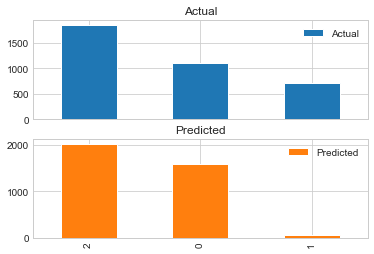

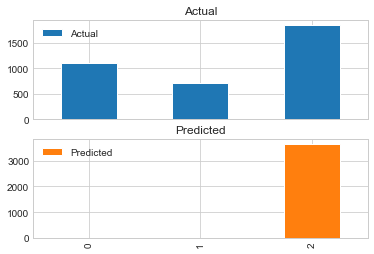

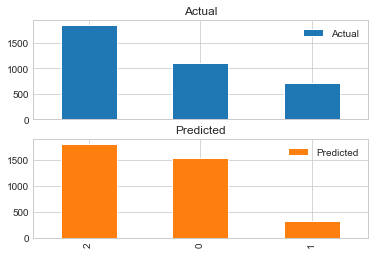

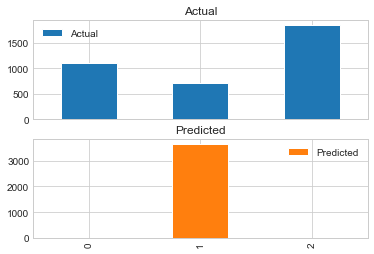

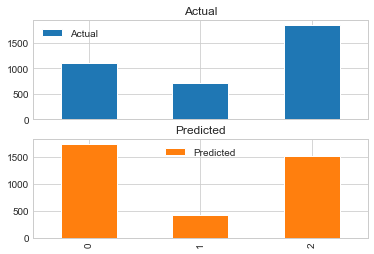

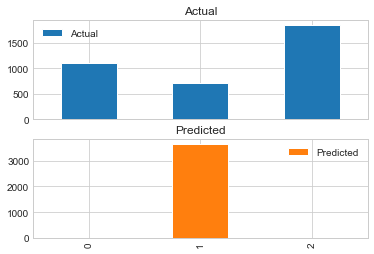

In [83]:
statistical_cols = ['mae','mse','rmse','precision','accuracy','f1-score','type','Tuning']
results = list()
tuning =[True,False]
types = ['RSSI Only','Rolling Mean RSSI','Both']
for feature in types:
    #Decide on type of data
    if feature == 'RSSI Only':
        trainX_data = train_X_rssi
        testX_data = test_X_rssi
    elif feature == 'Rolling Mean RSSI':
        trainX_data = train_X_rolling_mean
        testX_data = test_X_rolling_mean
    else:
        trainX_data = combination_features_X
        testX_data = test_combination_features_X 
    scaler = StandardScaler()
    scaler.fit(trainX_data)
    testX_data = scaler.transform(testX_data)
    for tune in tuning:
        if tune == True:
            model = KNeighborsClassifier(n_neighbors=12,metric=selected_distance,
                             weights=selected_weight)  
        else: 
            model = KNeighborsClassifier()
        trainX_data = scaler.transform(trainX_data)
        model.fit(trainX_data,train_Y.ravel())
        predicted = model.predict(testX_data)
        matrix = confusion_matrix(test_Y.ravel(), predicted)
        report = classification_report(test_Y.ravel(), predicted,output_dict=True)
        accuracy = accuracy_score(test_Y.ravel(),predicted)
        statistical_array = list()
        statistics = pd.DataFrame(report).transpose()
        error_dataframe = pd.DataFrame({'Actual': test_Y.flatten(), 'Predicted':predicted.flatten()})
        print("Confusion Matrix:")
        print(matrix)
        display(statistics)
        display(error_dataframe)
        error_dataframe.apply(pd.value_counts).plot(kind='bar', subplots=True)
        error = pd.DataFrame(np.where(error_dataframe['Actual'] != error_dataframe['Predicted'],1,0), columns=["error"])
        result = pd.DataFrame(train_Y,columns=["zone"]).join(error)
        data = structure_data(result,statistics['precision'].mean(),accuracy,statistics['f1-score'].mean())
        data.append(feature)
        data.append(tune)
        results.append(data)
statistics = pd.DataFrame(columns=statistical_cols,data=results)
display(statistics.sort_values(by=['f1-score'],ascending=False))
final_results.append(statistics.sort_values(by=['f1-score'],ascending=False).head(1).values[0])

### Best Results - Home Testing data (using data recovered from Android 10 SAMSUNG Galaxy A71 BIG Dataset)
Experiment with testing dataset

Confusion Matrix:
[[3857    0  938]
 [   0    0    0]
 [1037  459 6184]]


D:\Programs\Anaconda\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,precision,recall,f1-score,support
0,0.788108,0.804380,0.796161,4795.00000
1,0.000000,0.000000,0.000000,0.00000
2,0.868295,0.805208,0.835563,7680.00000
accuracy,0.804890,0.804890,0.804890,0.80489
macro avg,0.552134,0.536529,0.543908,12475.00000
weighted avg,0.837474,0.804890,0.820418,12475.00000


,Actual,Predicted
0,0,0
1,0,0
2,0,0
3,0,0
4,0,0
...,...,...
12470,2,0
12471,2,0
12472,2,0
12473,2,0


Confusion Matrix:
[[   0 4795]
 [   0 7680]]


D:\Programs\Anaconda\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,precision,recall,f1-score,support
0,0.000000,0.000000,0.000000,4795.000000
2,0.615631,1.000000,0.762094,7680.000000
accuracy,0.615631,0.615631,0.615631,0.615631
macro avg,0.307816,0.500000,0.381047,12475.000000
weighted avg,0.379002,0.615631,0.469169,12475.000000


,Actual,Predicted
0,0,2
1,0,2
2,0,2
3,0,2
4,0,2
...,...,...
12470,2,2
12471,2,2
12472,2,2
12473,2,2


Confusion Matrix:
[[4160   32  603]
 [   0    0    0]
 [1190 1561 4929]]


D:\Programs\Anaconda\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,precision,recall,f1-score,support
0,0.777570,0.867570,0.820108,4795.000000
1,0.000000,0.000000,0.000000,0.000000
2,0.890998,0.641797,0.746140,7680.000000
accuracy,0.728577,0.728577,0.728577,0.728577
macro avg,0.556189,0.503122,0.522083,12475.000000
weighted avg,0.847400,0.728577,0.774571,12475.000000


,Actual,Predicted
0,0,0
1,0,0
2,0,0
3,0,0
4,0,0
...,...,...
12470,2,1
12471,2,2
12472,2,2
12473,2,2


Confusion Matrix:
[[   0 4795    0]
 [   0    0    0]
 [   0 7680    0]]


D:\Programs\Anaconda\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\Programs\Anaconda\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,precision,recall,f1-score,support
0,0.0,0.0,0.0,4795.0
1,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,7680.0
accuracy,0.0,0.0,0.0,0.0
macro avg,0.0,0.0,0.0,12475.0
weighted avg,0.0,0.0,0.0,12475.0


,Actual,Predicted
0,0,1
1,0,1
2,0,1
3,0,1
4,0,1
...,...,...
12470,2,1
12471,2,1
12472,2,1
12473,2,1


Confusion Matrix:
[[4298   31  466]
 [   0    0    0]
 [1875 1570 4235]]


D:\Programs\Anaconda\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,precision,recall,f1-score,support
0,0.696258,0.896350,0.783735,4795.000000
1,0.000000,0.000000,0.000000,0.000000
2,0.900872,0.551432,0.684113,7680.000000
accuracy,0.684008,0.684008,0.684008,0.684008
macro avg,0.532377,0.482594,0.489282,12475.000000
weighted avg,0.822225,0.684008,0.722404,12475.000000


,Actual,Predicted
0,0,0
1,0,0
2,0,0
3,0,0
4,0,0
...,...,...
12470,2,2
12471,2,2
12472,2,2
12473,2,2


Confusion Matrix:
[[   0 4795    0]
 [   0    0    0]
 [   0 7680    0]]


D:\Programs\Anaconda\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\Programs\Anaconda\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,precision,recall,f1-score,support
0,0.0,0.0,0.0,4795.0
1,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,7680.0
accuracy,0.0,0.0,0.0,0.0
macro avg,0.0,0.0,0.0,12475.0
weighted avg,0.0,0.0,0.0,12475.0


,Actual,Predicted
0,0,1
1,0,1
2,0,1
3,0,1
4,0,1
...,...,...
12470,2,1
12471,2,1
12472,2,1
12473,2,1


,mae,mse,rmse,precision,accuracy,f1-score,type,Tuning
0,0.195110,0.195110,0.441713,0.641817,0.804890,0.633490,RSSI Only,True
2,0.271423,0.271423,0.520983,0.633456,0.728577,0.598580,Rolling Mean RSSI,True
4,0.315992,0.315992,0.562132,0.605957,0.684008,0.560590,Both,True
1,0.384369,0.384369,0.619975,0.383616,0.615631,0.445588,RSSI Only,False
3,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,Rolling Mean RSSI,False
5,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,Both,False


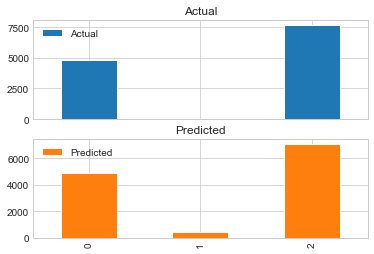

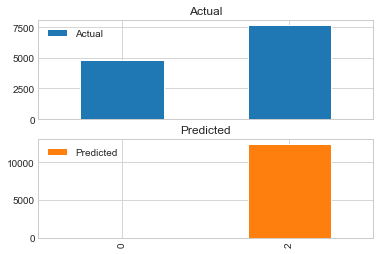

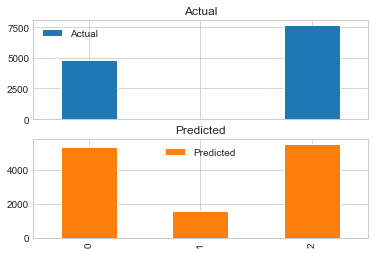

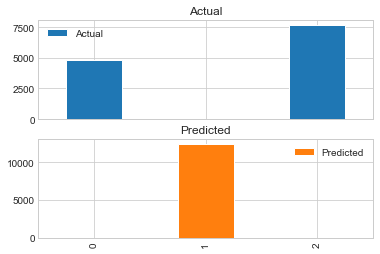

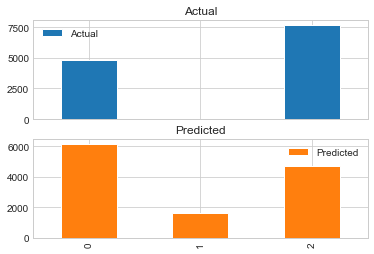

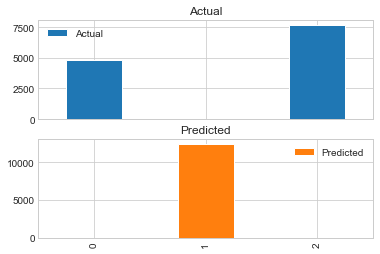

In [84]:
statistical_cols = ['mae','mse','rmse','precision','accuracy','f1-score','type','Tuning']
results = list()
tuning =[True,False]
types = ['RSSI Only','Rolling Mean RSSI','Both']
for feature in types:
    #Decide on type of data
    if feature == 'RSSI Only':
        trainX_data = train_X_rssi
        testX_data = test_X_rssi_home_big
    elif feature == 'Rolling Mean RSSI':
        trainX_data = train_X_rolling_mean
        testX_data = test_X_rolling_mean_home_big
    else:
        trainX_data = combination_features_X
        testX_data = test_combination_features_X_home_big
    scaler = StandardScaler()
    scaler.fit(trainX_data)
    testX_data = scaler.transform(testX_data)
    for tune in tuning:
        if tune == True:
            model = KNeighborsClassifier(n_neighbors=12,metric=selected_distance,
                             weights=selected_weight)  
        else: 
            model = KNeighborsClassifier()
        trainX_data = scaler.transform(trainX_data)
        model.fit(trainX_data,train_Y.ravel())
        predicted = model.predict(testX_data)
        matrix = confusion_matrix(test_Y_home_big.ravel(), predicted)
        report = classification_report(test_Y_home_big.ravel(), predicted,output_dict=True)
        accuracy = accuracy_score(test_Y_home_big.ravel(),predicted)
        statistical_array = list()
        statistics = pd.DataFrame(report).transpose()
        error_dataframe = pd.DataFrame({'Actual': test_Y_home_big.flatten(), 'Predicted':predicted.flatten()})
        print("Confusion Matrix:")
        print(matrix)
        display(statistics)
        display(error_dataframe)
        error_dataframe.apply(pd.value_counts).plot(kind='bar', subplots=True)
        error = pd.DataFrame(np.where(error_dataframe['Actual'] != error_dataframe['Predicted'],1,0), columns=["error"])
        result = pd.DataFrame(train_Y,columns=["zone"]).join(error)
        data = structure_data(result,statistics['precision'].mean(),accuracy,statistics['f1-score'].mean())
        data.append(feature)
        data.append(tune)
        results.append(data)
statistics = pd.DataFrame(columns=statistical_cols,data=results)
display(statistics.sort_values(by=['f1-score'],ascending=False))
final_results.append(statistics.sort_values(by=['f1-score'],ascending=False).head(1).values[0])

### Best Results - Home Testing data (using data recovered from Android 10 SAMSUNG Galaxy A71 Small Dataset)
Experiment with testing dataset

Confusion Matrix:
[[ 556   23  278]
 [   0    0    0]
 [ 276   64 1087]]


D:\Programs\Anaconda\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,precision,recall,f1-score,support
0,0.668269,0.648775,0.658378,857.000000
1,0.000000,0.000000,0.000000,0.000000
2,0.796337,0.761738,0.778653,1427.000000
accuracy,0.719352,0.719352,0.719352,0.719352
macro avg,0.488202,0.470171,0.479010,2284.000000
weighted avg,0.748284,0.719352,0.733524,2284.000000


,Actual,Predicted
0,0,0
1,0,0
2,0,0
3,0,0
4,0,0
...,...,...
2279,2,2
2280,2,2
2281,2,2
2282,2,2


D:\Programs\Anaconda\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Confusion Matrix:
[[   0  857]
 [   0 1427]]


,precision,recall,f1-score,support
0,0.000000,0.000000,0.000000,857.000000
2,0.624781,1.000000,0.769065,1427.000000
accuracy,0.624781,0.624781,0.624781,0.624781
macro avg,0.312391,0.500000,0.384532,2284.000000
weighted avg,0.390351,0.624781,0.480497,2284.000000


,Actual,Predicted
0,0,2
1,0,2
2,0,2
3,0,2
4,0,2
...,...,...
2279,2,2
2280,2,2
2281,2,2
2282,2,2


D:\Programs\Anaconda\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Confusion Matrix:
[[540  65 252]
 [  0   0   0]
 [226 290 911]]


,precision,recall,f1-score,support
0,0.704961,0.630105,0.665434,857.000000
1,0.000000,0.000000,0.000000,0.000000
2,0.783319,0.638402,0.703475,1427.000000
accuracy,0.635289,0.635289,0.635289,0.635289
macro avg,0.496093,0.422836,0.456303,2284.000000
weighted avg,0.753918,0.635289,0.689201,2284.000000


,Actual,Predicted
0,0,0
1,0,0
2,0,0
3,0,0
4,0,0
...,...,...
2279,2,1
2280,2,1
2281,2,2
2282,2,2


Confusion Matrix:
[[   0  857    0]
 [   0    0    0]
 [   0 1427    0]]


D:\Programs\Anaconda\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\Programs\Anaconda\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,precision,recall,f1-score,support
0,0.0,0.0,0.0,857.0
1,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,1427.0
accuracy,0.0,0.0,0.0,0.0
macro avg,0.0,0.0,0.0,2284.0
weighted avg,0.0,0.0,0.0,2284.0


,Actual,Predicted
0,0,1
1,0,1
2,0,1
3,0,1
4,0,1
...,...,...
2279,2,1
2280,2,1
2281,2,1
2282,2,1


Confusion Matrix:
[[552 108 197]
 [  0   0   0]
 [290 360 777]]


D:\Programs\Anaconda\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,precision,recall,f1-score,support
0,0.655582,0.644107,0.649794,857.000000
1,0.000000,0.000000,0.000000,0.000000
2,0.797741,0.544499,0.647230,1427.000000
accuracy,0.581874,0.581874,0.581874,0.581874
macro avg,0.484441,0.396202,0.432341,2284.000000
weighted avg,0.744400,0.581874,0.648192,2284.000000


,Actual,Predicted
0,0,0
1,0,0
2,0,0
3,0,0
4,0,0
...,...,...
2279,2,1
2280,2,2
2281,2,2
2282,2,1


Confusion Matrix:
[[   0  857    0]
 [   0    0    0]
 [   0 1427    0]]


D:\Programs\Anaconda\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\Programs\Anaconda\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,precision,recall,f1-score,support
0,0.0,0.0,0.0,857.0
1,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,1427.0
accuracy,0.0,0.0,0.0,0.0
macro avg,0.0,0.0,0.0,2284.0
weighted avg,0.0,0.0,0.0,2284.0


,Actual,Predicted
0,0,1
1,0,1
2,0,1
3,0,1
4,0,1
...,...,...
2279,2,1
2280,2,1
2281,2,1
2282,2,1


,mae,mse,rmse,precision,accuracy,f1-score,type,Tuning
0,0.280648,0.280648,0.529762,0.570074,0.719352,0.561486,RSSI Only,True
2,0.364711,0.364711,0.603913,0.562263,0.635289,0.524950,Rolling Mean RSSI,True
4,0.418126,0.418126,0.646627,0.544006,0.581874,0.493239,Both,True
1,0.375219,0.375219,0.612551,0.390461,0.624781,0.451775,RSSI Only,False
3,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,Rolling Mean RSSI,False
5,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,Both,False


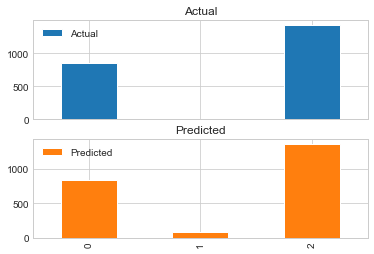

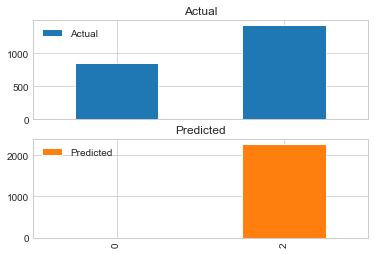

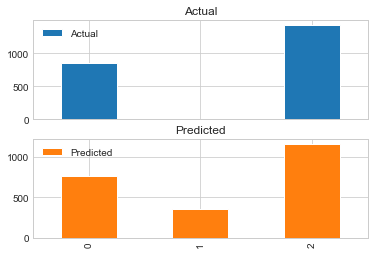

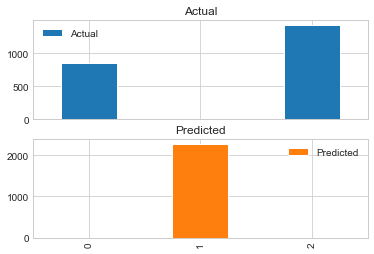

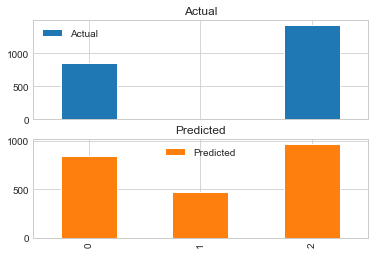

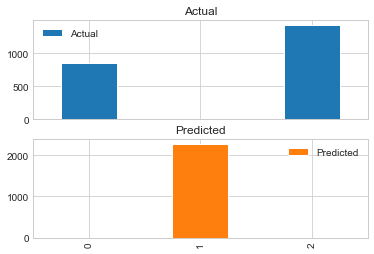

In [85]:
statistical_cols = ['mae','mse','rmse','precision','accuracy','f1-score','type','Tuning']
results = list()
tuning =[True,False]
types = ['RSSI Only','Rolling Mean RSSI','Both']
for feature in types:
    #Decide on type of data
    if feature == 'RSSI Only':
        trainX_data = train_X_rssi
        testX_data = test_X_rssi_home_small
    elif feature == 'Rolling Mean RSSI':
        trainX_data = train_X_rolling_mean
        testX_data = test_X_rolling_mean_home_small
    else:
        trainX_data = combination_features_X
        testX_data = test_combination_features_X_home_small
    scaler = StandardScaler()
    scaler.fit(trainX_data)
    testX_data = scaler.transform(testX_data)
    for tune in tuning:
        if tune == True:
            model = KNeighborsClassifier(n_neighbors=12,metric=selected_distance,
                             weights=selected_weight)  
        else: 
            model = KNeighborsClassifier()
        trainX_data = scaler.transform(trainX_data)
        model.fit(trainX_data,train_Y.ravel())
        predicted = model.predict(testX_data)
        matrix = confusion_matrix(test_Y_home_small.ravel(), predicted)
        report = classification_report(test_Y_home_small.ravel(), predicted,output_dict=True)
        accuracy = accuracy_score(test_Y_home_small.ravel(),predicted)
        statistical_array = list()
        statistics = pd.DataFrame(report).transpose()
        error_dataframe = pd.DataFrame({'Actual': test_Y_home_small.flatten(), 'Predicted':predicted.flatten()})
        print("Confusion Matrix:")
        print(matrix)
        display(statistics)
        display(error_dataframe)
        error_dataframe.apply(pd.value_counts).plot(kind='bar', subplots=True)
        error = pd.DataFrame(np.where(error_dataframe['Actual'] != error_dataframe['Predicted'],1,0), columns=["error"])
        result = pd.DataFrame(train_Y,columns=["zone"]).join(error)
        data = structure_data(result,statistics['precision'].mean(),accuracy,statistics['f1-score'].mean())
        data.append(feature)
        data.append(tune)
        results.append(data)
statistics = pd.DataFrame(columns=statistical_cols,data=results)
display(statistics.sort_values(by=['f1-score'],ascending=False))
final_results.append(statistics.sort_values(by=['f1-score'],ascending=False).head(1).values[0])

### Best Results - Home Testing data (using data recovered from ASUS ZENFONE LIVE)
Experiment with testing dataset

Confusion Matrix:
[[ 97   1  58]
 [  0   0   0]
 [ 39   7 213]]


D:\Programs\Anaconda\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,precision,recall,f1-score,support
0,0.713235,0.621795,0.664384,156.000000
1,0.000000,0.000000,0.000000,0.000000
2,0.785978,0.822394,0.803774,259.000000
accuracy,0.746988,0.746988,0.746988,0.746988
macro avg,0.499738,0.481396,0.489386,415.000000
weighted avg,0.758634,0.746988,0.751376,415.000000


,Actual,Predicted
0,0,0
1,0,0
2,0,0
3,0,0
4,0,0
...,...,...
410,2,2
411,2,2
412,2,2
413,2,2


Confusion Matrix:
[[  0 156]
 [  0 259]]


D:\Programs\Anaconda\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,precision,recall,f1-score,support
0,0.000000,0.000000,0.000000,156.000000
2,0.624096,1.000000,0.768546,259.000000
accuracy,0.624096,0.624096,0.624096,0.624096
macro avg,0.312048,0.500000,0.384273,415.000000
weighted avg,0.389496,0.624096,0.479647,415.000000


,Actual,Predicted
0,0,2
1,0,2
2,0,2
3,0,2
4,0,2
...,...,...
410,2,2
411,2,2
412,2,2
413,2,2


Confusion Matrix:
[[105   4  47]
 [  0   0   0]
 [ 26  39 194]]


D:\Programs\Anaconda\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,precision,recall,f1-score,support
0,0.801527,0.673077,0.731707,156.000000
1,0.000000,0.000000,0.000000,0.000000
2,0.804979,0.749035,0.776000,259.000000
accuracy,0.720482,0.720482,0.720482,0.720482
macro avg,0.535502,0.474037,0.502569,415.000000
weighted avg,0.803681,0.720482,0.759350,415.000000


,Actual,Predicted
0,0,0
1,0,0
2,0,0
3,0,0
4,0,0
...,...,...
410,2,1
411,2,2
412,2,2
413,2,2


Confusion Matrix:
[[  0 156   0]
 [  0   0   0]
 [  0 259   0]]


D:\Programs\Anaconda\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\Programs\Anaconda\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,precision,recall,f1-score,support
0,0.0,0.0,0.0,156.0
1,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,259.0
accuracy,0.0,0.0,0.0,0.0
macro avg,0.0,0.0,0.0,415.0
weighted avg,0.0,0.0,0.0,415.0


,Actual,Predicted
0,0,1
1,0,1
2,0,1
3,0,1
4,0,1
...,...,...
410,2,1
411,2,1
412,2,1
413,2,1


Confusion Matrix:
[[106  11  39]
 [  0   0   0]
 [ 33  68 158]]


D:\Programs\Anaconda\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,precision,recall,f1-score,support
0,0.762590,0.679487,0.718644,156.000000
1,0.000000,0.000000,0.000000,0.000000
2,0.802030,0.610039,0.692982,259.000000
accuracy,0.636145,0.636145,0.636145,0.636145
macro avg,0.521540,0.429842,0.470542,415.000000
weighted avg,0.787205,0.636145,0.702629,415.000000


,Actual,Predicted
0,0,0
1,0,0
2,0,0
3,0,0
4,0,0
...,...,...
410,2,2
411,2,1
412,2,1
413,2,2


Confusion Matrix:
[[  0 156   0]
 [  0   0   0]
 [  0 259   0]]


D:\Programs\Anaconda\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\Programs\Anaconda\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,precision,recall,f1-score,support
0,0.0,0.0,0.0,156.0
1,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,259.0
accuracy,0.0,0.0,0.0,0.0
macro avg,0.0,0.0,0.0,415.0
weighted avg,0.0,0.0,0.0,415.0


,Actual,Predicted
0,0,1
1,0,1
2,0,1
3,0,1
4,0,1
...,...,...
410,2,1
411,2,1
412,2,1
413,2,1


,mae,mse,rmse,precision,accuracy,f1-score,type,Tuning
2,0.279518,0.279518,0.528695,0.611029,0.720482,0.581685,Rolling Mean RSSI,True
0,0.253012,0.253012,0.503003,0.584095,0.746988,0.575985,RSSI Only,True
4,0.363855,0.363855,0.603204,0.584918,0.636145,0.536824,Both,True
1,0.375904,0.375904,0.613110,0.389947,0.624096,0.451312,RSSI Only,False
3,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,Rolling Mean RSSI,False
5,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,Both,False


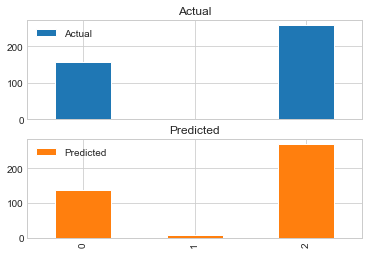

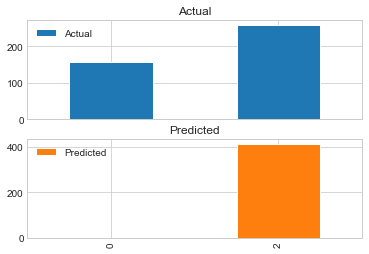

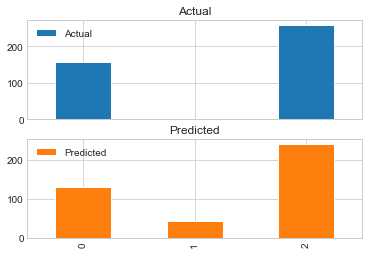

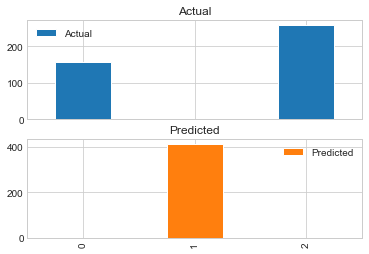

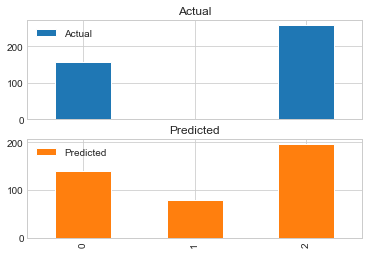

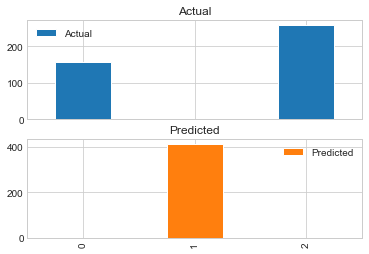

In [86]:
statistical_cols = ['mae','mse','rmse','precision','accuracy','f1-score','type','Tuning']
results = list()
tuning =[True,False]
types = ['RSSI Only','Rolling Mean RSSI','Both']
for feature in types:
    #Decide on type of data
    if feature == 'RSSI Only':
        trainX_data = train_X_rssi
        testX_data = test_X_rssi_home_asus
    elif feature == 'Rolling Mean RSSI':
        trainX_data = train_X_rolling_mean
        testX_data = test_X_rolling_mean_home_asus
    else:
        trainX_data = combination_features_X
        testX_data = test_combination_features_X_home_asus
    scaler = StandardScaler()
    scaler.fit(trainX_data)
    testX_data = scaler.transform(testX_data)
    for tune in tuning:
        if tune == True:
            model = KNeighborsClassifier(n_neighbors=12,metric=selected_distance,
                             weights=selected_weight)  
        else: 
            model = KNeighborsClassifier()
        trainX_data = scaler.transform(trainX_data)
        model.fit(trainX_data,train_Y.ravel())
        predicted = model.predict(testX_data)
        matrix = confusion_matrix(test_Y_home_asus.ravel(), predicted)
        report = classification_report(test_Y_home_asus.ravel(), predicted,output_dict=True)
        accuracy = accuracy_score(test_Y_home_asus.ravel(),predicted)
        statistical_array = list()
        statistics = pd.DataFrame(report).transpose()
        error_dataframe = pd.DataFrame({'Actual': test_Y_home_asus.flatten(), 'Predicted':predicted.flatten()})
        print("Confusion Matrix:")
        print(matrix)
        display(statistics)
        display(error_dataframe)
        error_dataframe.apply(pd.value_counts).plot(kind='bar', subplots=True)
        error = pd.DataFrame(np.where(error_dataframe['Actual'] != error_dataframe['Predicted'],1,0), columns=["error"])
        result = pd.DataFrame(train_Y,columns=["zone"]).join(error)
        data = structure_data(result,statistics['precision'].mean(),accuracy,statistics['f1-score'].mean())
        data.append(feature)
        data.append(tune)
        results.append(data)
statistics = pd.DataFrame(columns=statistical_cols,data=results)
display(statistics.sort_values(by=['f1-score'],ascending=False))
final_results.append(statistics.sort_values(by=['f1-score'],ascending=False).head(1).values[0])

### Results Display

,mae,mse,rmse,precision,accuracy,f1-score,type,Tuning
1,0.130879,0.130879,0.361773,0.870816,0.869121,0.869192,Both,None
0,0.223863,0.223863,0.473141,0.766506,0.776137,0.764626,Both,None
3,0.195110,0.195110,0.441713,0.641817,0.804890,0.633490,RSSI Only,True
5,0.279518,0.279518,0.528695,0.611029,0.720482,0.581685,Rolling Mean RSSI,True
4,0.280648,0.280648,0.529762,0.570074,0.719352,0.561486,RSSI Only,True
2,0.397879,0.397879,0.630776,0.546577,0.602121,0.541579,Rolling Mean RSSI,True


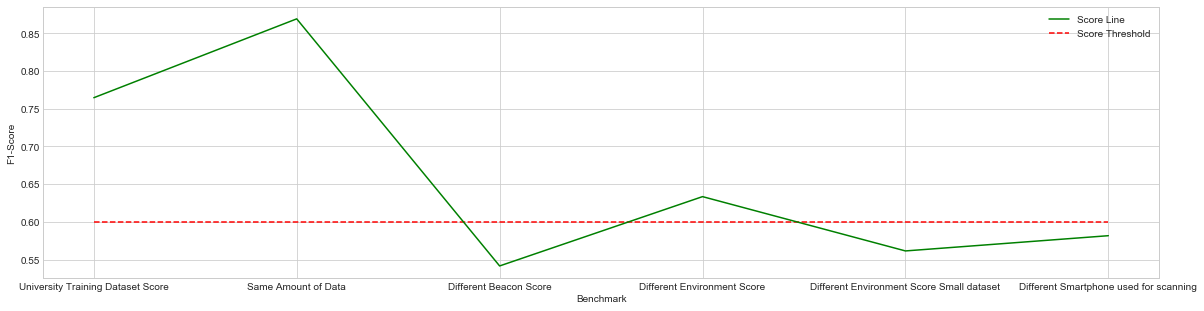

In [87]:
statistical_cols = ['mae','mse','rmse','precision','accuracy','f1-score','type','Tuning']
types = ['University Training Dataset Score','Same Amount of Data','Different Beacon Score','Different Environment Score','Different Environment Score Small dataset',
        "Different Smartphone used for scanning"]
results = pd.DataFrame(data=final_results,columns=statistical_cols)
display(results.sort_values(by=['f1-score'],ascending=False))
plt.figure(figsize=(20,5))
plt.plot(types,results['f1-score'],color='green',label='Score Line')
plt.hlines(0.6,0,5,color='red',label='Score Threshold',linestyles='dashed')
plt.xlabel('Benchmark')
plt.ylabel('F1-Score')
plt.legend(loc='upper right');
plt.show()